# 列舉所有資產的riskiness r

In [1]:
import sympy
from pandas import Series,DataFrame
from scipy.optimize import fsolve
import math
import time
import pandas as pd
import numpy  as  np
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 無風險利率
* 我們須扣除無風險利率，得到超額報酬率以計算Riskiness r
* 目前使用LIBOR [1個月利率](https://www.global-rates.com/interest-rates/libor/american-dollar/usd-libor-interest-rate-overnight.aspx)

In [2]:
rfrate = 2.45785 / 12 /100
rfrate

0.0020482083333333333

# 自定義 functions，用來計算風險指標
- get_riskiness_r(guess , arr_returns)
    - 計算Riskiness R
- get_all_risk_with_return_data(df)
    - 傳入多組ETF的月報酬序列資料，分別計算各組ETF的Riskiness R
- get_top5(df)
    - 依照R值排序，並傳回前5名的ETF
    
### 關於超額報酬的數量級:
* 將要帶入公式的數值調整到介在0-100間，目的是為了讓大部分的Riskiness r介在0-100間。

In [3]:
def f1(x,arr_returns):
    arr_returns = arr_returns
    return np.mean( np.exp(-1*arr_returns/x) ) - 1
def get_riskiness_r(guess , arr_returns):
    while (guess<10**(2)):
        risk2 = fsolve(f1,guess,arr_returns)  #引用函數f1
        #print('guess:',guess,'risk:',risk2,"value:",f1(risk2,arr_returns))
        if (risk2 != guess) and (f1(risk2,arr_returns)<0.1):
            break
        guess = guess*10
    return risk2

def get_all_risk_with_return_data(df):
    global rfrate
    
    etf_list = list(df.columns)
    etf_risk = []
    
    # 計算每支ETF的riskiness r
    for etf_name in etf_list:
        etf_returns = df[etf_name] - rfrate  
        guess = 10**(-5)
        risk_r = get_riskiness_r(guess,etf_returns)
        etf_risk.append([etf_name,risk_r])
        
    df = pd.DataFrame(etf_risk,columns=['Name','Riskiness R'])
    return df

def get_top5(df):
    df_sorted = df.sort_values(by=['Riskiness R'])
    df_top5 = df_sorted[:5]
    return df_top5

# 自定義 functions，用來計算最佳配置的權重值


In [4]:
def risk(x):
    guess  = 10**(-5)
    while (guess<1000):
        risk2 = fsolve(f1,guess,x)  #引用函數f1
        if risk2[0] != guess:
            break
        guess = guess*10
    return risk2[0]
    #return np.std(x)

def sumrisk(weight,all_return):
    w = weight
    a = all_return
    v = 0
    for i in range(len(w)):
        v = v + w[i]*risk(w[i]*(all_return.iloc[:,i]))
    return v

def penalty(w):
    if min(w)<0 or max(w)>1:
        return 100000
    else:
        return 0

def portretmean(weight,all_return):
    w = weight
    a = all_return
    return np.mean(np.dot(np.array(all_return),np.array(weight)))    

def bestweight(w,all_return):
    r = []
    r.append(penalty(w)+np.abs(sum(w)-1)*1000)
    for i in range(len(w)-1):
        v =  np.abs( risk(w[i]*(all_return.iloc[:,i]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i])-rfrate)/(portretmean(w,all_return)-rfrate) ) \
            + np.abs( risk(w[i+1]*(all_return.iloc[:,i+1]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i+1])-rfrate)/(portretmean(w,all_return)-rfrate))
        r.append(v) 
    print('權重:',w,'誤差值:',v+penalty(w)+np.abs(sum(w)-1))
    return r

def fourdrop(x):
    a = []
    for i in range(len(x)):
        a.append(round(sum(x[i]),3))
    return a

# 完整的處理流程

依序產生以下檔案

- 每月資料夾下有4個檔案
    - all_group_return.csv：用來存所有群組的月報酬(該月報酬即為該群前5名ETF的月報酬之平均值)
    - all_group_risk.csv：用來存每個群組的Riskiness R(該Riskiness R是以該群月報酬去計算)
    - top5_group_list.csv：用來存所有群組中Riskiness R最小的前5名
    - top5_group_weight.csv：用來存前5名群組的最佳配置權重
    
- 每群資料夾下也有4個檔案
    - all_etf_return.csv：用來存該群中所有ETF的月報酬資料
    - all_etf_risk.csv：用來存該群中每支ETF以月報酬計算出來的Riskiness R
    - top5_etf_list.csv：用來存該群中前5名的ETF(以 Riskiness R 排序)
    - top5_etf_return.csv：用來存該群中前5名的ETF的月報酬取之平均值

In [5]:
def get_total_months(data_path):
    subdir = os.listdir(data_path)[0] #取第一個group的csv檔
    file_path = data_path + subdir + '/' + subdir + '_return.csv'
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        total_rows = df.shape[0]
        return total_rows

In [6]:
return_data_path = '../2014to2018RE_data/'
risk_data_path = '../2017to2019Risk_data/'

# 以程式取得資料總筆數
total_data = get_total_months(return_data_path)
print('共有',total_data,'個月的資料')

# 指定用來計算指標的資料個數
window_size = 36
print('取',window_size,'個月的資料計算風險指標')

rolling_times = total_data - window_size
print('共滾動',rolling_times,'次')

共有 61 個月的資料
取 36 個月的資料計算風險指標
共滾動 25 次


In [7]:
for i in range(rolling_times):
    print('=== Rolling #',i+1,'===')
    
    #第一層目錄
    first_month = '2017-01-01'
    first_date = datetime.strptime(first_month,'%Y-%m-%d')
    the_date = first_date + relativedelta(months=i)
    date_string = the_date.strftime('%Y-%m-%d')
    risk_dir_path = os.path.join(risk_data_path,date_string)
    if not os.path.exists(risk_dir_path):
        os.makedirs(risk_dir_path)
        print('新增資料夾',risk_dir_path)
        
    #第二層目錄
    risk_dir_path_2nd = os.path.join(risk_dir_path,'all_groups/')
    if not os.path.exists(risk_dir_path_2nd):
        os.makedirs(risk_dir_path_2nd)
        print('新增資料夾',risk_dir_path_2nd)

    allgroup_top5_return = DataFrame()
    allgroup_top5_dict = dict()
    
    for subdir in os.listdir(return_data_path):
        #第三層目錄(group name)
        risk_dir_path_3rd = os.path.join(risk_dir_path_2nd,subdir)
        if not os.path.exists(risk_dir_path_3rd):
            os.makedirs(risk_dir_path_3rd)
            print('新增資料夾',risk_dir_path_3rd)
        
        subdir_path = os.path.join(return_data_path,subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            file = subdir + '_return.csv'
            file_path = os.path.join(subdir_path, file)
            if os.path.isfile(file_path):
                df = pd.read_csv(file_path)
                df_return = df.iloc[i:i+window_size,2:]
                print(df_return.shape)
                df_return = df_return.dropna(axis=1)
                print(df_return.shape)
                
                #第三層目錄下的檔案
                # 0. all_etf_return.csv
                csv_file = "all_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_return.to_csv(save_path,index=False)
                
                # 1. all_etf_risk.csv
                df_etf_risk = get_all_risk_with_return_data(df_return)
                csv_file = "all_etf_risk.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_etf_risk.to_csv(save_path,index=False)
                
                # 2. top5_etf_list.csv
                df_top5_etf = get_top5(df_etf_risk)
                csv_file = "top5_etf_list.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_top5_etf.to_csv(save_path,index=False)
                
                # 3. top5_etf_return.csv
                top5_etf = df_top5_etf['Name']
                top5_return_average = df_return[top5_etf].mean(axis=1)
                allgroup_top5_return[subdir] = top5_return_average
                
                csv_file = "top5_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                top5_return_average.to_csv(save_path,index=False)
                
                # 4. the_group_risk.csv
                # 改在第二層
                
                #[ top5_etf,allgroup_top5_return[subdir] ] = get_top5_etf(df)
                print('Group:',subdir)
                print('Top5:',top5_etf)
                print('================')
                #allgroup_top5_dict[subdir] = top5_etf
                
    #第二層
    # 4. all_group_return
    csv_file = "all_group_return.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    allgroup_top5_return.to_csv(save_path,index=False)
    
    # 5. all_group_risk
    df_group_risk = get_all_risk_with_return_data(allgroup_top5_return)
    csv_file = "all_group_risk.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_group_risk.to_csv(save_path,index=False)
    
    # 6. top5_group_list
    df_top5_group = get_top5(df_group_risk)
    csv_file = "top5_group_list.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_top5_group.to_csv(save_path,index=False)
    
    # 7. top_group_weight
    top5_group = df_top5_group['Name']    
    top5_group_return = allgroup_top5_return[top5_group]
    n = top5_group_return.shape[1]
    weight = [1/n]*n
    top5_group_best_weight = fsolve(bestweight,weight,top5_group_return)
    print(top5_group_best_weight)
    
    weight_list = []
    for i,group_name in enumerate(top5_group):
        group_weight = top5_group_best_weight[i]
        weight_list.append([group_name,group_weight])
    
    df_best_weight = pd.DataFrame(weight_list,columns=['Name','Weight'])
    print(df_best_weight)
    
    csv_file = "top5_group_weight.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_best_weight.to_csv(save_path,index=False)


=== Rolling # 1 ===
(36, 21)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     MNA
4     HDG
3    FLAG
9     QAI
5    MCRO
Name: Name, dtype: object
(36, 27)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 10     FPA
3      AIA
9     EEMA
7     DBAP
2     ADRA
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 19    DDP
58    SZO
28    DTO
7     BOS
54    SCO
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
18     VCR
3     FDIS
19     XLY
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
12     VDC
2     FSTA
3      FXG
7     PSCC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 7     EUFX
22     UUP
6      DRR
8      EUO
21    USDU
Name: Name, dtype: object
(36, 61)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 1      DFJ
37     SCJ
10    DXJS
11    ENZL
0     DBJP
Name: Name, dtype: object
(36, 80)
(36, 66)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
55     SMH
34     IXJ
39     KXI
50     RXI
Name: Name, dtype: object
(36, 58)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
0     ACIM
17    GRID
9      EXI
15    GOEX
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
7     FTAG
5     FDTS
11     IPO
Name: Name, dtype: object
(36, 78)
(36, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 39    INCO
52    SMIN
27     EWM
50    SCIF
46     PEK
Name: Name, dtype: object
(36, 44)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 18     EEV
11     EDZ
9      EDC
14     EEM
25    FEMS
Name: Name, dtype: object
(36, 60)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 19    GRID
10     FAN
50    YMLP
41     PZD
36    PSCE
Name: Name, dtype: object
(36, 42)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 18    KBWP
29     RYF
21     KIE
33     VFH
7     FNCL
Name: Name, dtype: object
(36, 40)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 13    FONE
19     IFV
9     FIEG
0     AADR
8      FAN
Name: Name, dtype: object
(36, 12)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10    UGLD
1     DGLD
4      DZZ
3      DGZ
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 9     IHI
21    XHE
8     IHF
18    RYH
23    XLV
Name: Name, dtype: object
(36, 26)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
19    XAR
18    VIS
14    RGI
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 0     CBND
11    USIG
8     QLTA
1     CORP
12    VCLT
Name: Name, dtype: object
(36, 20)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    RIGS
10    PGHY
0     ANGL
1     CJNK
11     PHB
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
27     PKB
8      FXZ
6     FMAT
33     RTM
Name: Name, dtype: object
(36, 14)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4      PZA
2      MUB
1      MLN
5     RVNU
10     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 14     PSR
19     RWR
21    SCHH
7      ICF
26     VNQ
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
0    BSCJ
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 33     XLK
12    PSCT
21     RYT
32     VGT
17    QTEC
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
7     XTL
2    FONE
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 20    XMPT
10    ILTB
5     BOND
3      BLV
17    SCHZ
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 6     DTYL
23     TLH
13     PLW
35    VGLT
18    SPTL
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 2      FXU
13     XLU
8     PSCU
12     VPU
1     FUTY
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.551520844703324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.551520844703324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.551520844703324
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5515208658629707
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5515208344599474
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5515208551947623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5515208418639297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5515208442142885
權重: [0.07381394 0.37430254 0.16324404 0.10993979 0.2786997 ] 誤差值: 0.9727734903197993
權重: [-0.04424564  0.5396845   0.22600455 -0.01815276  0.29671323] 誤差值: 100006.38562349888
權重: [0.09799221 0.44138348 0.17946937 0.19169178 0.33751416] 誤差值: 0.7265562480148682
權重: [0.07381394 0.37430254 0.16324404 0.10993979 0.2786997 ] 誤差值: 0.9727734926091121
權重: [0.07381394 0.37430254 0.16324404 0.10993979 0.2786997 ] 誤差值: 0.9727734774756945
權重: [0.07381394 0.37430254 0.16324404 0.10993979 0.2786997 ] 誤差值: 0.9727734951076685
權重: [0.07381394 0.37430254 0.16324404 0.10993979 0.2786997 ] 誤差值: 0.9727734936584601
權重:

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     HDG
6     MNA
3    FLAG
9     QAI
5    MCRO
Name: Name, dtype: object
(36, 27)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
10     FPA
9     EEMA
2     ADRA
7     DBAP
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 19     DDP
58     SZO
28     DTO
7      BOS
43    KOLD
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
18     VCR
3     FDIS
19     XLY
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
12     VDC
2     FSTA
4      IYK
3      FXG
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 7     EUFX
22     UUP
6      DRR
8      EUO
21    USDU
Name: Name, dtype: object
(36, 61)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
38     SCJ
11    DXJS
26    FNDC
34    JPXN
Name: Name, dtype: object
(36, 80)
(36, 66)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
55     SMH
39     KXI
50     RXI
0     ACWI
Name: Name, dtype: object
(36, 58)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
0     ACIM
10     EXI
13     FPA
4     DBAW
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
7     FTAG
11     IPO
6      FLM
Name: Name, dtype: object
(36, 78)
(36, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 52    SMIN
39    INCO
54     THD
40    INDA
35     GMF
Name: Name, dtype: object
(36, 44)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 30     PXH
0     ADRE
32    SCHE
26    FNDE
34    TLTE
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 10     FAN
19    GRID
41     PZD
32     NLR
50    YMLP
Name: Name, dtype: object
(36, 42)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 18    KBWP
21     KIE
29     RYF
33     VFH
8      FXO
Name: Name, dtype: object
(36, 40)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
20     IFV
10    FIEG
2     DBAW
Name: Name, dtype: object
(36, 12)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10    UGLD
1     DGLD
8     SGOL
0      DGL
6      GLL
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 9     IHI
8     IHF
21    XHE
18    RYH
23    XLV
Name: Name, dtype: object
(36, 26)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
8     IYJ
14    RGI
18    VIS
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
12    VCLT
0     CBND
11    USIG
6      LQD
Name: Name, dtype: object
(36, 20)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10    PGHY
12    RIGS
0     ANGL
1     CJNK
11     PHB
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
27     PKB
33     RTM
8      FXZ
6     FMAT
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4      PZA
5     RVNU
1      MLN
2      MUB
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 14     PSR
19     RWR
21    SCHH
5     GQRE
29    WREI
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 33     XLK
12    PSCT
21     RYT
5      IGM
32     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
4     IYZ
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    XMPT
5     BOND
11    ILTB
7     FWDB
3      BLV
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 23     TLH
13     PLW
35    VGLT
18    SPTL
37    ZROZ
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
13     XLU
12     VPU
1     FUTY
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4989847691245737
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4989847691245737
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4989847691245737
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4989847707699724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49898477148766496
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49898476971887096
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49898474672997395
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49898479295015363
權重: [ 0.28004308 -0.25810391  0.30332541  0.35455129  0.32018412] 誤差值: 100002.21261950299
權重: [0.34290519 0.3119429  0.32167665 0.28222726 0.3086145 ] 誤差值: 0.9530370404065373
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.4989847707699724
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49898477148766496
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49898476971887096
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49898474672997395
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.49898479295015363
權重: [ 0.28004308 -0.25810391  0.30332541  0.35455129  0.32018412] 誤差值: 100002.21261950299
權重: [0.34290519 0.3119429  0.32167665 0.28222726 0.3086145 ] 誤差值: 0.953037040

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     HDG
6     MNA
3    FLAG
9     QAI
5    MCRO
Name: Name, dtype: object
(36, 27)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
10     FPA
9     EEMA
2     ADRA
0     AAXJ
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 19     DDP
58     SZO
28     DTO
43    KOLD
54     SCO
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
18     VCR
3     FDIS
19     XLY
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
12     VDC
2     FSTA
4      IYK
8      PSL
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22     UUP
7     EUFX
6      DRR
8      EUO
21    USDU
Name: Name, dtype: object
(36, 61)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
39     SCJ
11    DXJS
35    JPXN
24     FJP
Name: Name, dtype: object
(36, 80)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
56     SMH
40     KXI
25    HEFA
51     RXI
Name: Name, dtype: object
(36, 58)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 2      CIL
0     ACIM
21    IPKW
10     EXI
4     DBAW
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
7     FTAG
5     FDTS
6      FLM
Name: Name, dtype: object
(36, 78)
(36, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 52    SMIN
39    INCO
49     PIN
40    INDA
51    SCIN
Name: Name, dtype: object
(36, 44)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 30     PXH
3      BKF
33    SPEM
32    SCHE
0     ADRE
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 10     FAN
41     PZD
19    GRID
50    YMLP
3     ATMP
Name: Name, dtype: object
(36, 42)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 18    KBWP
21     KIE
29     RYF
33     VFH
8      FXO
Name: Name, dtype: object
(36, 40)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
20     IFV
0     AADR
2     DBAW
10    FIEG
Name: Name, dtype: object
(36, 12)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10    UGLD
1     DGLD
4      DZZ
3      DGZ
6      GLL
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 9     IHI
21    XHE
8     IHF
18    RYH
23    XLV
Name: Name, dtype: object
(36, 26)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 12    PPA
7     ITA
19    XAR
8     IYJ
14    RGI
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
0     CBND
12    VCLT
8     QLTA
6      LQD
Name: Name, dtype: object
(36, 20)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10    PGHY
12    RIGS
0     ANGL
1     CJNK
5     HYLS
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
27     PKB
33     RTM
8      FXZ
6     FMAT
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4      PZA
5     RVNU
1      MLN
2      MUB
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 14     PSR
19     RWR
21    SCHH
10     IYR
7      ICF
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 33     XLK
32     VGT
5      IGM
21     RYT
2     FTEC
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
6     VOX
2    FONE
7     XTL
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    XMPT
5     BOND
11    ILTB
3      BLV
7     FWDB
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 23     TLH
13     PLW
35    VGLT
18    SPTL
37    ZROZ
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
2      FXU
13     XLU
12     VPU
1     FUTY
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.243967109971216
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.243967109971216
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.243967109971216
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.243967109649545
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.243967110853785
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.243967107460974
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2439670814611263
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2439671316210277
權重: [ 0.29604867 -0.28303626  0.31975655  0.3741428   0.29308824] 誤差值: 100002.0362898857
權重: [0.34423391 0.31590412 0.32050421 0.27378351 0.34059483] 誤差值: 1.5290928309967522
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.243967109649545
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.243967110853785
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.243967107460974
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2439670814611263
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2439671316210277
權重: [ 0.29604867 -0.28303626  0.31975655  0.3741428   0.29308824] 誤差值: 100002.0362898857
權重: [0.34423391 0.31590412 0.32050421 0.27378351 0.34059483] 誤差值: 1.5290928309967522
權重: [0.2716

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     HDG
6     MNA
3    FLAG
9     QAI
5    MCRO
Name: Name, dtype: object
(36, 27)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
10     FPA
7     DBAP
9     EEMA
0     AAXJ
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 19     DDP
58     SZO
28     DTO
43    KOLD
54     SCO
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
3     FDIS
18     VCR
19     XLY
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
2     FSTA
12     VDC
4      IYK
8      PSL
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
3    OLO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22     UUP
7     EUFX
6      DRR
8      EUO
21    USDU
Name: Name, dtype: object
(36, 61)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
39     SCJ
11    DXJS
35    JPXN
24     FJP
Name: Name, dtype: object
(36, 80)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
56     SMH
40     KXI
51     RXI
25    HEFA
Name: Name, dtype: object
(36, 58)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 0     ACIM
21    IPKW
2      CIL
10     EXI
4     DBAW
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
11     IPO
7     FTAG
5     FDTS
Name: Name, dtype: object
(36, 78)
(36, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 53    SMIN
39    INCO
35     GMF
2      AIA
50     PIN
Name: Name, dtype: object
(36, 44)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
26    FEMS
31     PXH
0     ADRE
35    TLTE
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 10     FAN
19    GRID
41     PZD
32     NLR
50    YMLP
Name: Name, dtype: object
(36, 42)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 18    KBWP
21     KIE
29     RYF
33     VFH
10     IAK
Name: Name, dtype: object
(36, 40)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
20     IFV
2     DBAW
29    SOCL
Name: Name, dtype: object
(36, 12)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10    UGLD
1     DGLD
4      DZZ
7      IAU
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 9     IHI
21    XHE
18    RYH
23    XLV
8     IHF
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
9     IYJ
15    RGI
20    XAR
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
12    VCLT
0     CBND
8     QLTA
6      LQD
Name: Name, dtype: object
(36, 20)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10    PGHY
12    RIGS
0     ANGL
1     CJNK
11     PHB
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
27     PKB
17     ITB
33     RTM
8      FXZ
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4      PZA
5     RVNU
1      MLN
2      MUB
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
14     PSR
10     IYR
11    KBWY
21    SCHH
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 33     XLK
5      IGM
16     QQQ
32     VGT
12    PSCT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    XMPT
5     BOND
11    ILTB
3      BLV
2      BIV
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 23     TLH
13     PLW
35    VGLT
18    SPTL
33     UST
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     XLU
12     VPU
2      FXU
9      PUI
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1899920223507745
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1899920223507745
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.1899920223507745
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18999203033773293
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18999201979251534
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18999203597554026
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18999201324706783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18999201086825934
權重: [ 0.23409857 -0.15261435  0.26701959  0.29838521  0.35311098] 誤差值: 100000.13473711004
權重: [0.06614538 0.13038167 0.09498559 0.12197903 0.17002533] 誤差值: 5.320663883212801
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18999203033773293
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18999201979251534
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18999203597554026
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18999201324706783
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.18999201086825934
權重: [ 0.23409857 -0.15261435  0.26701959  0.29838521  0.35311098] 誤差值: 100000.13473711004
權重: [0.06614538 0.13038167 0.09498559 0.12197903 0.17002533] 誤差值: 5.32066388

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     MNA
4     HDG
3    FLAG
9     QAI
5    MCRO
Name: Name, dtype: object
(36, 27)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
9     EEMA
10     FPA
0     AAXJ
7     DBAP
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 58     SZO
19     DDP
28     DTO
43    KOLD
54     SCO
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
18     VCR
3     FDIS
19     XLY
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
12     VDC
2     FSTA
4      IYK
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22     UUP
7     EUFX
6      DRR
8      EUO
21    USDU
Name: Name, dtype: object
(36, 61)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
40     SCJ
12    DXJS
36    JPXN
25     FJP
Name: Name, dtype: object
(36, 80)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
56     SMH
51     RXI
40     KXI
25    HEFA
Name: Name, dtype: object
(36, 58)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 0     ACIM
21    IPKW
10     EXI
2      CIL
4     DBAW
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
11     IPO
7     FTAG
6      FLM
Name: Name, dtype: object
(36, 78)
(36, 64)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 40    INCO
54    SMIN
36     GMF
2      AIA
41    INDA
Name: Name, dtype: object
(36, 44)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
26    FEMS
34    SPEM
35    TLTE
31     PXH
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 41     PZD
19    GRID
10     FAN
4      DDG
6      DUG
Name: Name, dtype: object
(36, 42)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
30     RYF
34     VFH
9      FXO
Name: Name, dtype: object
(36, 40)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
29    SOCL
0     AADR
20     IFV
2     DBAW
Name: Name, dtype: object
(36, 12)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10    UGLD
5      GLD
1     DGLD
2      DGP
3      DGZ
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 9     IHI
21    XHE
8     IHF
18    RYH
23    XLV
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
19    VIS
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
8     QLTA
6      LQD
12    VCLT
11    USIG
Name: Name, dtype: object
(36, 20)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 10    PGHY
12    RIGS
0     ANGL
1     CJNK
11     PHB
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
27     PKB
17     ITB
44     XHB
8      FXZ
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4     PZA
5    RVNU
1     MLN
2     MUB
0     ITM
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
14     PSR
11    KBWY
13    MORT
10     IYR
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 33     XLK
12    PSCT
5      IGM
21     RYT
16     QQQ
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    XMPT
5     BOND
12    ILTB
8     FWDB
3      BLV
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 23     TLH
13     PLW
35    VGLT
18    SPTL
33     UST
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     XLU
12     VPU
2      FXU
9      PUI
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831336001028
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831336001028
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831336001028
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831342922238
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831349596817
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831326787365
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831085484496
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831554912966
權重: [ 0.28568872 -0.28046477  0.31906208  0.36901565  0.30669832] 誤差值: 100002.06934458333
權重: [0.35048638 0.31596875 0.31987143 0.27718491 0.32905832] 誤差值: 1.232171496712121
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831342922238
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831349596817
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831326787365
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831085484496
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8730831554912966
權重: [ 0.28568872 -0.28046477  0.31906208  0.36901565  0.30669832] 誤差值: 100002.06934458333
權重: [0.35048638 0.31596875 0.31987143 0.27718491 0.32905832] 誤差值: 1.232171496712121
權重

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     MNA
4     HDG
3    FLAG
9     QAI
5    MCRO
Name: Name, dtype: object
(36, 27)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 12    IHDG
3      AIA
10     FPA
9     EEMA
0     AAXJ
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
43    KOLD
55     SCO
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
18     VCR
3     FDIS
19     XLY
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
12     VDC
2     FSTA
4      IYK
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
0    DBO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22     UUP
7     EUFX
6      DRR
8      EUO
3     CROC
Name: Name, dtype: object
(36, 61)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
40     SCJ
12    DXJS
36    JPXN
27    FNDC
Name: Name, dtype: object
(36, 80)
(36, 68)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
57     SMH
41     KXI
31    IHDG
52     RXI
Name: Name, dtype: object
(36, 58)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 0     ACIM
21    IPKW
10     EXI
2      CIL
20    IDHQ
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
11     IPO
5     FDTS
7     FTAG
Name: Name, dtype: object
(36, 78)
(36, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 41    INCO
55    SMIN
2      AIA
37     GMF
10      CN
Name: Name, dtype: object
(36, 44)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 0     ADRE
3      BKF
35    TLTE
34    SPEM
2     BICK
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 19    GRID
41     PZD
32     NLR
10     FAN
4      DDG
Name: Name, dtype: object
(36, 42)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
30     RYF
11     IAK
9      FXO
Name: Name, dtype: object
(36, 40)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 29    SOCL
14    FONE
0     AADR
20     IFV
2     DBAW
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
7      IAU
9     SGOL
5      GLD
0      DGL
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 9     IHI
21    XHE
8     IHF
18    RYH
23    XLV
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
15    RGI
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
8     QLTA
12    VCLT
0     CBND
6      LQD
Name: Name, dtype: object
(36, 20)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
1     CJNK
14    SHYG
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
27     PKB
17     ITB
33     RTM
44     XHB
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4      PZA
5     RVNU
1      MLN
11     TFI
0      ITM
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
14     PSR
10     IYR
13    MORT
7      ICF
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 12    PSCT
33     XLK
5      IGM
32     VGT
21     RYT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 23    XMPT
5     BOND
12    ILTB
3      BLV
8     FWDB
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 23     TLH
13     PLW
35    VGLT
18    SPTL
33     UST
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     XLU
12     VPU
9      PUI
1     FUTY
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7428032911050311
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7428032911050311
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7428032911050311
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.74280329225457
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.742803292731925
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7428032909588542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7428032668832474
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7428033130743206
權重: [ 0.2816477  -0.26778376  0.31242672  0.36330676  0.31040258] 誤差值: 100002.11485716671
權重: [0.35035459 0.31211781 0.31946964 0.27240902 0.3206329 ] 誤差值: 1.1603692629575257
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.74280329225457
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.742803292731925
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7428032909588542
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7428032668832474
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7428033130743206
權重: [ 0.2816477  -0.26778376  0.31242672  0.36330676  0.31040258] 誤差值: 100002.11485716671
權重: [0.35035459 0.31211781 0.31946964 0.27240902 0.3206329 ] 誤差值: 1.1603692629575257
權重: [0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     MNA
4     HDG
3    FLAG
9     QAI
5    MCRO
Name: Name, dtype: object
(36, 27)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    IHDG
3      AIA
10    EEMA
11     FPA
8     DBAP
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
43    KOLD
55     SCO
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
18     VCR
3     FDIS
19     XLY
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 9      RHS
8      PSL
4      IYK
2     FSTA
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22     UUP
7     EUFX
6      DRR
8      EUO
3     CROC
Name: Name, dtype: object
(36, 61)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
42     SCJ
35    JPMV
12    DXJS
1     DBKO
Name: Name, dtype: object
(36, 80)
(36, 70)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
59     SMH
31    IHDG
40    JPGE
42     KXI
Name: Name, dtype: object
(36, 58)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 11     EXI
0     ACIM
22    IPKW
2      CIL
21    IDHQ
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
11     IPO
5     FDTS
7     FTAG
Name: Name, dtype: object
(36, 78)
(36, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 42    INCO
56    SMIN
2      AIA
11      CN
38     GMF
Name: Name, dtype: object
(36, 44)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26    FEMS
0     ADRE
19     EEV
3      BKF
12     EDZ
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 19    GRID
41     PZD
4      DDG
6      DUG
10     FAN
Name: Name, dtype: object
(36, 42)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
30     RYF
34     VFH
9      FXO
Name: Name, dtype: object
(36, 40)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
30    SOCL
0     AADR
20     IFV
2     DBAW
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
4      DZZ
1     DGLD
6      GLL
3      DGZ
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 9     IHI
21    XHE
8     IHF
18    RYH
23    XLV
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
15    RGI
Name: Name, dtype: object
(36, 22)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
9     QLTA
13    VCLT
6      LQD
12    USIG
Name: Name, dtype: object
(36, 20)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    RIGS
11    PGHY
0     ANGL
1     CJNK
12     PHB
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
27     PKB
17     ITB
3      CUT
44     XHB
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4      PZA
5     RVNU
1      MLN
0      ITM
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 14     PSR
5     GQRE
10     IYR
7      ICF
13    MORT
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 12    PSCT
5      IGM
33     XLK
7      IGV
21     RYT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    IUSB
24    XMPT
12    ILTB
5     BOND
3      BLV
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 23     TLH
13     PLW
35    VGLT
18    SPTL
1     DFVL
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     XLU
12     VPU
9      PUI
1     FUTY
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209649172892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209649172892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209649172892
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209662262414
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209661871323
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209655895831
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209403973224
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209865216141
權重: [ 0.29050164 -0.27026695  0.31010241  0.36153106  0.30813183] 誤差值: 100002.08487669908
權重: [0.34519605 0.31372128 0.32259968 0.2729386  0.3242813 ] 誤差值: 1.1223327694634415
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209662262414
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209661871323
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209655895831
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209403973224
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.6809209865216141
權重: [ 0.29050164 -0.27026695  0.31010241  0.36153106  0.30813183] 誤差值: 100002.08487669908
權重: [0.34519605 0.31372128 0.32259968 0.2729386  0.3242813 ] 誤差值: 1.1223327694634415


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     MNA
4     HDG
3    FLAG
9     QAI
5    MCRO
Name: Name, dtype: object
(36, 27)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    IHDG
3      AIA
10    EEMA
11     FPA
0     AAXJ
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
43    KOLD
55     SCO
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
18     VCR
3     FDIS
19     XLY
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
4      IYK
12     VDC
2     FSTA
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 22     UUP
6      DRR
7     EUFX
8      EUO
3     CROC
Name: Name, dtype: object
(36, 61)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
42     SCJ
35    JPMV
27    FNDC
12    DXJS
Name: Name, dtype: object
(36, 80)
(36, 70)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
40    JPGE
59     SMH
42     KXI
54     RXI
Name: Name, dtype: object
(36, 58)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 11     EXI
22    IPKW
0     ACIM
19    GRID
31     PZD
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
11     IPO
5     FDTS
6      FLM
Name: Name, dtype: object
(36, 78)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 43    INCO
57    SMIN
2      AIA
39     GMF
36     FNI
Name: Name, dtype: object
(36, 44)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26    FEMS
3      BKF
7      DGS
36    TLTE
4     DBEM
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 19    GRID
41     PZD
32     NLR
10     FAN
4      DDG
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
11     IAK
9      FXO
Name: Name, dtype: object
(36, 40)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FONE
0     AADR
30    SOCL
2     DBAW
10    FIEG
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
6      GLL
1     DGLD
3      DGZ
2      DGP
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 9     IHI
21    XHE
18    RYH
8     IHF
23    XLV
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
19    VIS
Name: Name, dtype: object
(36, 22)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
9     QLTA
6      LQD
0     CBND
13    VCLT
Name: Name, dtype: object
(36, 20)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    RIGS
11    PGHY
0     ANGL
6     HYLS
12     PHB
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
17     ITB
27     PKB
45     XHB
3      CUT
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4     PZA
5    RVNU
1     MLN
0     ITM
2     MUB
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
13    MORT
14     PSR
10     IYR
11    KBWY
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 12    PSCT
13     PSJ
5      IGM
7      IGV
21     RYT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    IUSB
6     BYLD
24    XMPT
5     BOND
12    ILTB
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 24     TLH
36    VGLT
13     PLW
18    SPTL
34     UST
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
13     XLU
12     VPU
1     FUTY
9      PUI
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7036212287233226
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7036212287233226
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7036212287233226
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7036212373283547
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.703621225692869
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7036212424456916
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7036212058450031
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7036212230710294
權重: [ 0.35601728 -1.51124141  0.3461445   0.35477996  1.45429966] 誤差值: 100000.40330511914
權重: [0.4052474  0.25726943 0.40568958 0.40436872 0.1796385 ] 誤差值: 1.0057951681055852
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7036212373283547
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.703621225692869
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7036212424456916
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7036212058450031
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.7036212230710294
權重: [ 0.35601728 -1.51124141  0.3461445   0.35477996  1.45429966] 誤差值: 100000.40330511914
權重: [0.4052474  0.25726943 0.40568958 0.40436872 0.1796385 ] 誤差值: 1.0057951681055852
權重

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     MNA
4     HDG
9     QAI
3    FLAG
5    MCRO
Name: Name, dtype: object
(36, 27)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    IHDG
3      AIA
10    EEMA
8     DBAP
0     AAXJ
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
43    KOLD
55     SCO
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
6      IYC
18     VCR
3     FDIS
20     XLY
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
4      IYK
12     VDC
2     FSTA
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
8    USO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
22     UUP
8      EUO
7     EUFX
3     CROC
Name: Name, dtype: object
(36, 61)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
42     SCJ
35    JPMV
27    FNDC
12    DXJS
Name: Name, dtype: object
(36, 80)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
60     SMH
41    JPGE
18    FNDC
32    IHDG
Name: Name, dtype: object
(36, 58)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 23    IPKW
12     EXI
0     ACIM
20    GRID
22    IDHQ
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
5     FDTS
11     IPO
3      EFO
Name: Name, dtype: object
(36, 78)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 43    INCO
57    SMIN
2      AIA
39     GMF
11      CN
Name: Name, dtype: object
(36, 44)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26    FEMS
25     FEM
3      BKF
7      DGS
35    SPEM
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 19    GRID
41     PZD
32     NLR
4      DDG
10     FAN
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
9      FXO
35     VFH
Name: Name, dtype: object
(36, 40)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
30    SOCL
14    FONE
2     DBAW
9      FAN
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
2      DGP
7      IAU
5      GLD
8     OUNZ
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 9     IHI
21    XHE
18    RYH
23    XLV
8     IHF
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
19    VIS
Name: Name, dtype: object
(36, 22)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
9     QLTA
6      LQD
13    VCLT
12    USIG
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    RIGS
11    PGHY
0     ANGL
6     HYLS
14    SHYG
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
17     ITB
27     PKB
3      CUT
45     XHB
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4      PZA
5     RVNU
1      MLN
0      ITM
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
13    MORT
14     PSR
10     IYR
17     REM
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13     PSJ
12    PSCT
7      IGV
5      IGM
33     XLK
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
2    FONE
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    IUSB
25    XMPT
5     BOND
6     BYLD
12    ILTB
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 18    SPTL
24     TLH
36    VGLT
13     PLW
34     UST
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     XLU
12     VPU
1     FUTY
9      PUI
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8709238508317767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8709238508317767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8709238508317767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8709238521036788
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8709238513931623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8709238497305996
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8709238168240454
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.870923879923112
權重: [ 0.38420113 -1.24056595  1.09916779  0.38102207  0.37617496] 誤差值: 100000.4455948921
權重: [0.40335526 0.27285405 0.17242453 0.40298361 0.40421115] 誤差值: 1.0920872005515752
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8709238521036788
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8709238513931623
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8709238497305996
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8709238168240454
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.870923879923112
權重: [ 0.38420113 -1.24056595  1.09916779  0.38102207  0.37617496] 誤差值: 100000.4455948921
權重: [0.40335526 0.27285405 0.17242453 0.40298361 0.40421115] 誤差值: 1.0920872005515752
權重: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      MNA
4     FTLS
5      HDG
3     FLAG
10     QAI
Name: Name, dtype: object
(36, 27)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
10    EEMA
21    VXUS
9      DNL
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
43    KOLD
49    PALL
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14     RTH
18     VCR
3     FDIS
6      IYC
20     XLY
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
4      IYK
9      RHS
7     PSCC
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
7    USL
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
0      BZF
22     UUP
3     CROC
Name: Name, dtype: object
(36, 61)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
42     SCJ
27    FNDC
35    JPMV
32    IDHQ
Name: Name, dtype: object
(36, 80)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
18    FNDC
41    JPGE
3      CGW
58     SCZ
Name: Name, dtype: object
(36, 58)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 24    IPKW
13     EXI
0     ACIM
23    IDHQ
21    GRID
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
5     FDTS
6      FLM
11     IPO
Name: Name, dtype: object
(36, 78)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
24    EEMA
39     GMF
57    SMIN
43    INCO
Name: Name, dtype: object
(36, 44)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
26    FEMS
25     FEM
4     DBEM
7      DGS
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 19    GRID
41     PZD
10     FAN
32     NLR
4      DDG
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
9      FXO
35     VFH
Name: Name, dtype: object
(36, 40)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
31    SOCL
14    FONE
25     LIT
9      FAN
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
11    UGLD
2      DGP
7      IAU
9     SGOL
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 9      IHI
21     XHE
15    PSCH
8      IHF
18     RYH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
19    VIS
Name: Name, dtype: object
(36, 22)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
10    QLTA
7      LQD
13    USIG
14    VCLT
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    RIGS
11    PGHY
14    SHYG
0     ANGL
12     PHB
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
27     PKB
17     ITB
3      CUT
45     XHB
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4     PZA
5    RVNU
1     MLN
0     ITM
2     MUB
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
13    MORT
17     REM
10     IYR
11    KBWY
Name: Name, dtype: object
(36, 16)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
2    BSCN
1    BSCM
Name: Name, dtype: object
(36, 47)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 13    PSCT
14     PSJ
22     RYT
6      IGM
8      IGV
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
7     XTL
6     VOX
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    IUSB
6     BYLD
8     FWDB
25    XMPT
5     BOND
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 24     TLH
1     DFVL
36    VGLT
13     PLW
34     UST
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
12     VPU
14     XLU
1     FUTY
9      PUI
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.137934106308027
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.137934106308027
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.137934106308027
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.137934121592405
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1379341191918098
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1379341207300833
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.137934093661536
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.137934085661506
權重: [ 2.31745584 -5.21661254  2.97743152  0.42080683  0.50091836] 誤差值: 100001.24016993104
權重: [0.23064361 0.29821864 0.24111338 0.40815753 0.40812089] 誤差值: 1.1027478512207547
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.137934121592405
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1379341191918098
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1379341207300833
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.137934093661536
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.137934085661506
權重: [ 2.31745584 -5.21661254  2.97743152  0.42080683  0.50091836] 誤差值: 100001.24016993104
權重: [0.23064361 0.29821864 0.24111338 0.40815753 0.40812089] 誤差值: 1.1027478512207547
權重: [0.23

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 8      MNA
5     FTLS
6      HDG
4     FLAG
11     QAI
Name: Name, dtype: object
(36, 27)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
3      AIA
10    EEMA
22    VXUS
9      DNL
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 59     SZO
19     DDP
28     DTO
43    KOLD
49    PALL
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 18     VCR
3     FDIS
14     RTH
6      IYC
20     XLY
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
4      IYK
9      RHS
7     PSCC
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
7     USL
2    OLEM
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
8      EUO
3     CROC
22     UUP
0      BZF
Name: Name, dtype: object
(36, 61)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
42     SCJ
27    FNDC
1     DBKO
35    JPMV
Name: Name, dtype: object
(36, 80)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
18    FNDC
41    JPGE
58     SCZ
54    ROBO
Name: Name, dtype: object
(36, 58)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 25    IPKW
14     EXI
0     ACIM
24    IDHQ
34     PZD
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
5     FDTS
13     PEX
6      FLM
11     IPO
Name: Name, dtype: object
(36, 78)
(36, 68)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
25    EEMA
40     GMF
44    INCO
58    SMIN
Name: Name, dtype: object
(36, 44)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26    FEMS
4     DBEM
7      DGS
3      BKF
29    IEMG
Name: Name, dtype: object
(36, 60)
(36, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 42     PZD
20    GRID
11     FAN
33     NLR
18     GEX
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
9      FXO
35     VFH
Name: Name, dtype: object
(36, 40)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
31    SOCL
14    FONE
9      FAN
25     LIT
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 9     SGOL
7      IAU
10     UBG
5      GLD
8     OUNZ
Name: Name, dtype: object
(36, 34)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
22     XHE
16    PSCH
9      IHF
19     RYH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
3     EXI
Name: Name, dtype: object
(36, 22)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
10    QLTA
14    VCLT
7      LQD
0     CBND
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    RIGS
11    PGHY
0     ANGL
14    SHYG
12     PHB
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
27     PKB
17     ITB
5      FLM
3      CUT
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4     PZA
5    RVNU
1     MLN
0     ITM
2     MUB
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
17     REM
13    MORT
14     PSR
11    KBWY
Name: Name, dtype: object
(36, 16)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
2    BSCN
1    BSCM
Name: Name, dtype: object
(36, 47)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14    PSCT
15     PSJ
7      IGM
23     RYT
35     XLK
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
7     XTL
6     VOX
0    ERUS
Name: Name, dtype: object
(36, 36)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    IUSB
11    FWDB
8     FCOR
29    XMPT
5     BOND
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 36    VGLT
24     TLH
38    ZROZ
13     PLW
8      EDV
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
12     VPU
14     XLU
9      PUI
1     FUTY
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9289317381759241
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9289317381759241
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9289317381759241
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.928931753101719
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9289317514008684
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9289317526389242
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9289317260718022
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9289317209530061
權重: [ 3.46957867 -8.01862909  4.55970148  0.44168412  0.54766481] 誤差值: 100001.09130917487
權重: [0.21854908 0.30446565 0.22806742 0.40884182 0.40759407] 誤差值: 0.9859487368887957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.928931753101719
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9289317514008684
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9289317526389242
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9289317260718022
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9289317209530061
權重: [ 3.46957867 -8.01862909  4.55970148  0.44168412  0.54766481] 誤差值: 100001.09130917487
權重: [0.21854908 0.30446565 0.22806742 0.40884182 0.40759407] 誤差值: 0.9859487368887957
權重

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     FTLS
6      HDG
8      MNA
4     FLAG
11     QAI
Name: Name, dtype: object
(36, 27)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
23    VXUS
10    EEMA
11     FPA
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 60     SZO
19     DDP
43    KOLD
49    PALL
28     DTO
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 18     VCR
3     FDIS
14     RTH
6      IYC
20     XLY
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
9      RHS
4      IYK
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
4    SCO
8    USO
6    UCO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 6      DRR
0      BZF
8      EUO
3     CROC
17     FXY
Name: Name, dtype: object
(36, 61)
(36, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
43     SCJ
36    JPMV
27    FNDC
39    JPXN
Name: Name, dtype: object
(36, 80)
(36, 72)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
18    FNDC
41    JPGE
59     SCZ
55    ROBO
Name: Name, dtype: object
(36, 58)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 25    IPKW
0     ACIM
14     EXI
24    IDHQ
22    GRID
Name: Name, dtype: object
(36, 28)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
5     FDTS
6      FLM
14     PEX
12     IPO
Name: Name, dtype: object
(36, 78)
(36, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
25    EEMA
41     GMF
45    INCO
59    SMIN
Name: Name, dtype: object
(36, 44)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 22    EMQQ
7      DGS
27    FEMS
3      BKF
30    IEMG
Name: Name, dtype: object
(36, 60)
(36, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GRID
42     PZD
11     FAN
33     NLR
43    QCLN
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
9      FXO
35     VFH
Name: Name, dtype: object
(36, 40)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
32    SOCL
14    FONE
26     LIT
9      FAN
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7     IAU
9    SGOL
5     GLD
8    OUNZ
2     DGP
Name: Name, dtype: object
(36, 34)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10     IHI
22     XHE
16    PSCH
9      IHF
19     RYH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
3     EXI
Name: Name, dtype: object
(36, 22)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
15    VCLT
10    QLTA
0     CBND
7      LQD
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 13    RIGS
11    PGHY
12     PHB
0     ANGL
14    SHYG
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
27     PKB
5      FLM
17     ITB
3      CUT
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4     PZA
5    RVNU
1     MLN
0     ITM
6     SHM
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 5     GQRE
2      DRW
17     REM
13    MORT
10     IYR
Name: Name, dtype: object
(36, 16)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
2    BSCN
3    BSCO
Name: Name, dtype: object
(36, 47)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 16    PSCT
17     PSJ
9      IGM
25     RYT
37     XLK
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
7     XTL
6     VOX
0    ERUS
Name: Name, dtype: object
(36, 36)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    IUSB
11    FWDB
29    XMPT
8     FCOR
5     BOND
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 30     TYD
36    VGLT
38    ZROZ
8      EDV
33     UBT
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
14     XLU
12     VPU
9      PUI
1     FUTY
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7498289884575877
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7498289884575877
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7498289884575877
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7498290025429497
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7498290014655666
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.749829003106591
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7498289748922737
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7498289759877494
權重: [ 3.43854468 -6.37632519  3.02384202  0.42274574  0.49119276] 誤差值: 100001.43288838689
權重: [0.22488016 0.29093377 0.22373496 0.40911989 0.40687842] 誤差值: 0.997081853301129
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7498290025429497
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7498290014655666
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.749829003106591
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7498289748922737
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7498289759877494
權重: [ 3.43854468 -6.37632519  3.02384202  0.42274574  0.49119276] 誤差值: 100001.43288838689
權重: [0.22488016 0.29093377 0.22373496 0.40911989 0.40687842] 誤差值: 0.997081853301129
權重: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     FTLS
8      MNA
6      HDG
4     FLAG
10    MRGR
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
23    VXUS
3      AIA
11     FPA
22     VEU
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
3      BDD
55     RJZ
49    PALL
60     SZO
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 18     VCR
3     FDIS
14     RTH
6      IYC
20     XLY
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
4      IYK
9      RHS
7     PSCC
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0     BZF
23    YCL
17    FXY
1     CEW
4     CYB
Name: Name, dtype: object
(36, 61)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
44     SCJ
37    JPMV
27    FNDC
1     DBKO
Name: Name, dtype: object
(36, 80)
(36, 73)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 19    FNDC
1     ACWV
42    JPGE
60     SCZ
25     GWX
Name: Name, dtype: object
(36, 58)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 26    IPKW
15     EXI
25    IDHQ
0     ACIM
23    GRID
Name: Name, dtype: object
(36, 28)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
5     FDTS
6      FLM
7     FPXI
12     IPO
Name: Name, dtype: object
(36, 78)
(36, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
25    EEMA
41     GMF
38     FNI
61     THD
Name: Name, dtype: object
(36, 44)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    TLTE
22    EMQQ
4     DBEM
7      DGS
27    FEMS
Name: Name, dtype: object
(36, 60)
(36, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GRID
43     PZD
11     FAN
36     PBD
44    QCLN
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
9      FXO
35     VFH
Name: Name, dtype: object
(36, 40)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
32    SOCL
14    FONE
9      FAN
2     DBAW
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
10     UBG
Name: Name, dtype: object
(36, 34)
(36, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12     IHI
24     XHE
18    PSCH
11     IHF
21     RYH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
9     IYJ
3     EXI
20    XAR
Name: Name, dtype: object
(36, 22)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 1     CORP
10    QLTA
7      LQD
15    VCLT
13    SPLB
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
6     HYLS
14    SHYG
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
27     PKB
17     ITB
5      FLM
8      FXZ
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4      PZA
5     RVNU
1      MLN
0      ITM
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 17     REM
13    MORT
2      DRW
5     GQRE
28    VNQI
Name: Name, dtype: object
(36, 16)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
8    IBDL
2    BSCN
Name: Name, dtype: object
(36, 47)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 37    XLK
9     IGM
13    IXN
36    VGT
25    RYT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
0    ERUS
6     VOX
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 17    IUSB
11    FWDB
8     FCOR
6     BYLD
5     BOND
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 1     DFVL
36    VGLT
38    ZROZ
8      EDV
33     UBT
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
12     VPU
9      PUI
1     FUTY
4      IDU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199234392177
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199234392177
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199234392177
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199322855394
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199330002224
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199082400456
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199253233166
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199258521756
權重: [-1.91278636  2.02827541  0.41143894  0.37163018  0.10144182] 誤差值: 100001.4066237561
權重: [0.20654162 0.15116964 0.40276915 0.40624469 0.4097001 ] 誤差值: 1.2708940987055102
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199322855394
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199330002224
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199082400456
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199253233166
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.4557199258521756
權重: [-1.91278636  2.02827541  0.41143894  0.37163018  0.10144182] 誤差值: 100001.4066237561
權重: [0.20654162 0.15116964 0.40276915 0.40624469 0.4097001 ] 誤差值: 1.2708940987055102
權重

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     FTLS
8      MNA
6      HDG
4     FLAG
13     RLY
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 23    VXUS
15    IHDG
22     VEU
3      AIA
7      CWI
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
3      BDD
10    CPER
44      LD
49    PALL
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 18     VCR
3     FDIS
20     XLY
6      IYC
14     RTH
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 4      IYK
8      PSL
9      RHS
7     PSCC
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
4     SCO
6     UCO
2    OLEM
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 1     CEW
4     CYB
0     BZF
20    URR
13    FXE
Name: Name, dtype: object
(36, 61)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
44     SCJ
27    FNDC
37    JPMV
1     DBKO
Name: Name, dtype: object
(36, 80)
(36, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 19    FNDC
1     ACWV
43    JPGE
61     SCZ
57    ROBO
Name: Name, dtype: object
(36, 58)
(36, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 15     EXI
27    IPKW
3      CIL
0     ACIM
25    IDHQ
Name: Name, dtype: object
(36, 28)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
5     FDTS
6      FLM
7     FPXI
14     PEX
Name: Name, dtype: object
(36, 78)
(36, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 2      AIA
25    EEMA
16    DBEM
41     GMF
19     DGS
Name: Name, dtype: object
(36, 44)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 4     DBEM
7      DGS
38    TLTE
30    IEMG
22    EMQQ
Name: Name, dtype: object
(36, 60)
(36, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GRID
43     PZD
11     FAN
36     PBD
44    QCLN
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
11     IAK
31     RYF
35     VFH
Name: Name, dtype: object
(36, 40)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
32    SOCL
14    FONE
9      FAN
34    VIDI
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
2      DGP
7      IAU
8     OUNZ
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12     IHI
24     XHE
18    PSCH
11     IHF
21     RYH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13     PPA
8      ITA
9      IYJ
3      EXI
4     FIDU
Name: Name, dtype: object
(36, 22)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8     LQDH
15    VCLT
1     CORP
13    SPLB
11    SKOR
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
13    RIGS
0     ANGL
6     HYLS
14    SHYG
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
5      FLM
27     PKB
8      FXZ
17     ITB
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4      PZA
5     RVNU
6      SHM
1      MLN
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 2      DRW
28    VNQI
24     TAO
17     REM
5     GQRE
Name: Name, dtype: object
(36, 16)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
8    IBDL
7    IBDD
Name: Name, dtype: object
(36, 47)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 37    XLK
9     IGM
25    RYT
36    VGT
13    IXN
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
1    FCOM
7     XTL
0    ERUS
6     VOX
Name: Name, dtype: object
(36, 36)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    FWDB
26    SPAB
30    XMPT
18    KCNY
8     FCOR
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5     DTUS
2     DFVS
7     DTYS
3     DLBS
18    SPTL
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 8     PSCU
12     VPU
5      IGF
1     FUTY
9      PUI
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
1    TVIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2830461013951524
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2830461013951524
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2830461013951524
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.28304610930053054
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.2830460988115864
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.28304609312367135
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.28304611334793095
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.28304611308553396
權重: [0.29234236 0.283226   0.1636911  0.08240446 0.17833608] 誤差值: 1.6150176664087403
權重: [0.15166478 0.25967306 0.21176943 0.16138852 0.21552058] 誤差值: 0.41450676026647415
權重: [0.11797317 0.24548944 0.19217132 0.22993481 0.21443125] 誤差值: 0.15490920882140302
權重: [0.0599783  0.27956116 0.18096947 0.26734235 0.21214873] 誤差值: 0.17380781472377427
權重: [-0.02958038  0.31681397  0.21970707  0.24122366  0.25183568] 誤差值: 100002.08133029264
權重: [0.08890592 0.30445639 0.22318474 0.32352324 0.24919606] 誤差值: 0.42202635746426354
權重: [0.0599783  0.27956116 0.18096947 0.26734235 0.21214873] 誤差值: 0.173807815

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6    FTLS
7     HDG
5    FLAG
9     MNA
4    DIVA
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
23    VXUS
6     CHIQ
11     FPA
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
3      BDD
55     RJZ
49    PALL
44      LD
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 18     VCR
3     FDIS
20     XLY
6      IYC
14     RTH
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
9      RHS
7     PSCC
4      IYK
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
1    DTO
6    UCO
7    USL
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0     BZF
17    FXY
2     CNY
23    YCL
20    URR
Name: Name, dtype: object
(36, 61)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
44     SCJ
37    JPMV
27    FNDC
1     DBKO
Name: Name, dtype: object
(36, 80)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 19    FNDC
1     ACWV
43    JPGE
62     SCZ
57    ROBO
Name: Name, dtype: object
(36, 58)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 3      CIL
28    IPKW
15     EXI
0     ACIM
24    GRID
Name: Name, dtype: object
(36, 28)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
5     FDTS
6      FLM
7     FPXI
15     PEX
Name: Name, dtype: object
(36, 78)
(36, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 30    EMQQ
2      AIA
61     THD
54     PGJ
51    KWEB
Name: Name, dtype: object
(36, 44)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 22    EMQQ
27    FEMS
7      DGS
39    XSOE
26     FEM
Name: Name, dtype: object
(36, 60)
(36, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 20    GRID
43     PZD
11     FAN
27     KOL
36     PBD
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
35     VFH
11     IAK
Name: Name, dtype: object
(36, 40)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    SOCL
0     AADR
14    FONE
9      FAN
27     LIT
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
5      GLD
9     SGOL
8     OUNZ
11    UGLD
Name: Name, dtype: object
(36, 34)
(36, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12     IHI
24     XHE
18    PSCH
11     IHF
21     RYH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
20    XAR
9     IYJ
5     FIW
Name: Name, dtype: object
(36, 22)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 8     LQDH
13    SPLB
15    VCLT
11    SKOR
0     CBND
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 11    PGHY
0     ANGL
13    RIGS
8      HYS
14    SHYG
Name: Name, dtype: object
(36, 52)
(36, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
5      FLM
8      FXZ
3      CUT
29     PKB
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 4     PZA
5    RVNU
6     SHM
1     MLN
0     ITM
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 25     TAO
2      DRW
18     REM
29    VNQI
14    MORT
Name: Name, dtype: object
(36, 16)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
8    IBDL
7    IBDD
Name: Name, dtype: object
(36, 47)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9     IGM
37    XLK
25    RYT
36    VGT
17    PSJ
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
0    ERUS
1    FCOM
7     XTL
6     VOX
Name: Name, dtype: object
(36, 36)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    FWDB
18    KCNY
31    XMPT
26    SPAB
7     FBND
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5     DTUS
7     DTYS
19    SPTL
3     DLBS
2     DFVS
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
13     VPU
15     XLU
1     FUTY
10     PUI
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.30509170772383043
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.30509170772383043
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.30509170772383043
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.30509171008533076
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3050917095264942
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3050917104122044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3050917318689652
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3050916855970618
權重: [-0.02064939  0.31836573  0.20603523  0.23267399  0.26357444] 誤差值: 100002.67762249519
權重: [0.17796619 0.22060706 0.13191899 0.11224486 0.13905831] 誤差值: 2.3596380822231806
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.30509171008533076
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3050917095264942
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3050917104122044
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3050917318689652
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3050916855970618
權重: [-0.02064939  0.31836573  0.20603523  0.23267399  0.26357444] 誤差值: 100002.67762249519
權重: [0.17796619 0.22060706 0.13191899 0.11224486 0.13905831] 誤差值: 2.359638082223

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
6     FTLS
13     QED
5     FLAG
14     QLS
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
9      DNL
15    IHDG
23    VXUS
10    EEMA
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
3      BDD
63     UBG
49    PALL
42     IAU
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 3     FDIS
18     VCR
20     XLY
6      IYC
15     RXI
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8     PSL
7    PSCC
9     RHS
4     IYK
5     KXI
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5    SZO
6    UCO
1    DTO
7    USL
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 13    FXE
0     BZF
2     CNY
19    ULE
17    FXY
Name: Name, dtype: object
(36, 61)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
44     SCJ
37    JPMV
27    FNDC
1     DBKO
Name: Name, dtype: object
(36, 80)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 75      XT
19    FNDC
1     ACWV
43    JPGE
62     SCZ
Name: Name, dtype: object
(36, 58)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 3      CIL
28    IPKW
15     EXI
0     ACIM
39     PZD
Name: Name, dtype: object
(36, 28)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 16    ROGS
1     CROP
5     FDTS
6      FLM
7     FPXI
Name: Name, dtype: object
(36, 78)
(36, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 62     THD
3      AIA
20     DGS
31    EMQQ
38    FEMS
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
22    EMQQ
27    FEMS
39    TLTE
26     FEM
Name: Name, dtype: object
(36, 60)
(36, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 43     PZD
20    GRID
11     FAN
34     NLR
27     KOL
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
11     IAK
35     VFH
Name: Name, dtype: object
(36, 40)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
33    SOCL
14    FONE
9      FAN
12      FM
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
7      IAU
9     SGOL
5      GLD
8     OUNZ
Name: Name, dtype: object
(36, 34)
(36, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12     IHI
24     XHE
18    PSCH
11     IHF
8     FHLC
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 13    PPA
8     ITA
5     FIW
20    XAR
9     IYJ
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 16    VCLT
14    SPLB
9     LQDH
12    SKOR
0     CBND
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
0     ANGL
14    RIGS
15    SHYG
9      HYS
Name: Name, dtype: object
(36, 52)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
8      FXZ
3      CUT
5      FLM
25     MOO
Name: Name, dtype: object
(36, 14)
(36, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 5     PZA
2     MLN
6    RVNU
7     SHM
3     MUB
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REM
2      DRW
30    VNQI
26     TAO
24    SRET
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
7    IBDD
2    BSCN
Name: Name, dtype: object
(36, 47)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9     IGM
37    XLK
25    RYT
17    PSJ
11    IGV
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
7     XTL
0    ERUS
1    FCOM
6     VOX
Name: Name, dtype: object
(36, 36)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    FWDB
31    XMPT
18    KCNY
26    SPAB
15    ILTB
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5     DTUS
2     DFVS
7     DTYS
19    SPTL
3     DLBS
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
13     VPU
1     FUTY
15     XLU
5      IDU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3922014531871305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3922014531871305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3922014531871305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3922014554539528
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.39220145460921163
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3922014556257769
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3922014306423933
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3922014769356077
權重: [0.54845193 0.15520488 0.00228555 0.17617151 0.11788614] 誤差值: 2.7588356522339677
權重: [0.1267851  0.21812612 0.14112061 0.25584696 0.25812122] 誤差值: 0.3445836178607935
權重: [0.14672284 0.26261627 0.10130348 0.28312287 0.20623454] 誤差值: 0.12154757375728309
權重: [0.08127345 0.29265196 0.07732521 0.30826697 0.24048242] 誤差值: 0.024491488975601383
權重: [-0.01258954  0.39700841 -0.01709472  0.35852979  0.27414606] 誤差值: 100002.22083609254
權重: [0.14679927 0.36516505 0.11882594 0.33876804 0.2669719 ] 誤差值: 0.27598458290776795
權重: [0.08127345 0.29265196 0.07732521 0.30826697 0.24048242] 誤差值: 0.024491489686

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
6     FTLS
13     QED
5     FLAG
14     QLS
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
23    VXUS
9      DNL
22     VEU
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 3      BDD
13     DBB
49    PALL
63     UBG
42     IAU
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 18     VCR
3     FDIS
20     XLY
6      IYC
14     RTH
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8     PSL
7    PSCC
9     RHS
4     IYK
5     KXI
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 5     SZO
1     DTO
6     UCO
7     USL
2    OLEM
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 2     CNY
0     BZF
17    FXY
23    YCL
20    URR
Name: Name, dtype: object
(36, 61)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
45     SCJ
38    JPMV
27    FNDC
1     DBKO
Name: Name, dtype: object
(36, 80)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 75      XT
19    FNDC
43    JPGE
1     ACWV
62     SCZ
Name: Name, dtype: object
(36, 58)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 3      CIL
28    IPKW
15     EXI
0     ACIM
39     PZD
Name: Name, dtype: object
(36, 28)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
16    ROGS
5     FDTS
6      FLM
15     PEX
Name: Name, dtype: object
(36, 78)
(36, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 46    INCO
62     THD
60    SMIN
3      AIA
31    EMQQ
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 22    EMQQ
7      DGS
40    XSOE
13     EEB
27    FEMS
Name: Name, dtype: object
(36, 60)
(36, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 43     PZD
20    GRID
11     FAN
34     NLR
27     KOL
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
11     IAK
9      FXO
Name: Name, dtype: object
(36, 40)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
33    SOCL
9      FAN
14    FONE
27     LIT
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 10     UBG
7      IAU
9     SGOL
5      GLD
8     OUNZ
Name: Name, dtype: object
(36, 34)
(36, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12     IHI
24     XHE
18    PSCH
11     IHF
22     VHT
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
9     IYJ
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 9     LQDH
14    SPLB
16    VCLT
12    SKOR
0     CBND
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
0     ANGL
9      HYS
15    SHYG
14    RIGS
Name: Name, dtype: object
(36, 52)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
20     ITB
3      CUT
8      FXZ
5      FLM
Name: Name, dtype: object
(36, 14)
(36, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 5     PZA
6    RVNU
2     MLN
7     SHM
0     ITM
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
5     PSK
2     PFF
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REM
24    SRET
14    MORT
2      DRW
6     GQRE
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
7    IBDD
2    BSCN
Name: Name, dtype: object
(36, 47)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9     IGM
25    RYT
37    XLK
17    PSJ
11    IGV
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
7     XTL
1    FCOM
0    ERUS
6     VOX
Name: Name, dtype: object
(36, 36)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    FWDB
31    XMPT
26    SPAB
15    ILTB
7     FBND
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5     DTUS
2     DFVS
7     DTYS
19    SPTL
3     DLBS
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
13     VPU
1     FUTY
15     XLU
10     PUI
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38590089177458986
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38590089177458986
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.38590089177458986
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3859008940651123
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3859008932412904
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3859008942134474
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3859008694556201
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3859009153021975
權重: [0.13527089 0.17656537 0.15285214 0.28803298 0.24727863] 誤差值: 0.2115810646414622
權重: [0.36780644 0.12722305 0.09328774 0.21928342 0.19240432] 誤差值: 0.5060112373087431
權重: [0.20140005 0.06798414 0.16458977 0.31276093 0.25327413] 誤差值: 0.5098209897257489
權重: [0.13527089 0.17656537 0.15285214 0.28803298 0.24727863] 誤差值: 0.21158106575072955
權重: [0.13527089 0.17656538 0.15285214 0.28803298 0.24727863] 誤差值: 0.21158106420069034
權重: [0.13527089 0.17656537 0.15285214 0.28803298 0.24727863] 誤差值: 0.2115810698660361
權重: [0.13527089 0.17656537 0.15285214 0.28803298 0.24727863] 誤差值: 0.211581072412516
權

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 7      HDG
13     QED
6     FTLS
5     FLAG
14     QLS
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
3      AIA
9      DNL
19     PAF
10    EEMA
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
3      BDD
55     RJZ
49    PALL
44      LD
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 18     VCR
3     FDIS
20     XLY
6      IYC
14     RTH
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8     PSL
7    PSCC
4     IYK
9     RHS
5     KXI
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1     DTO
5     SZO
2    OLEM
0     DBO
6     UCO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 17    FXY
23    YCL
0     BZF
2     CNY
20    URR
Name: Name, dtype: object
(36, 61)
(36, 50)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
48     SCJ
39    JPMV
46    SCIJ
27    FNDC
Name: Name, dtype: object
(36, 80)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 76      XT
1     ACWV
19    FNDC
44    JPGE
63     SCZ
Name: Name, dtype: object
(36, 58)
(36, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 4      CIL
32    ISCF
16     EXI
29    IPKW
25    GRID
Name: Name, dtype: object
(36, 28)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 16    ROGS
1     CROP
5     FDTS
17    SCID
6      FLM
Name: Name, dtype: object
(36, 78)
(36, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 62     THD
3      AIA
46    INCO
39     FNI
31    EMQQ
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 22    EMQQ
7      DGS
32     PIE
13     EEB
40    XSOE
Name: Name, dtype: object
(36, 60)
(36, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 21    GRID
45     PZD
12     FAN
15    FILL
29     KOL
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
9      FXO
35     VFH
Name: Name, dtype: object
(36, 40)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
33    SOCL
14    FONE
9      FAN
27     LIT
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
10     UBG
5      GLD
8     OUNZ
Name: Name, dtype: object
(36, 34)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12     IHI
26     XHE
20    PSCH
11     IHF
24     VHT
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
21    XAR
5     FIW
9     IYJ
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 16    VCLT
14    SPLB
9     LQDH
8      LQD
1     CORP
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
0     ANGL
9      HYS
15    SHYG
14    RIGS
Name: Name, dtype: object
(36, 52)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
3      CUT
8      FXZ
20     ITB
5      FLM
Name: Name, dtype: object
(36, 14)
(36, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 5      PZA
6     RVNU
2      MLN
0      ITM
12     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 24    SRET
18     REM
14    MORT
2      DRW
6     GQRE
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
3    BSCO
2    BSCN
Name: Name, dtype: object
(36, 47)
(36, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9     IGM
17    PSJ
38    XLK
25    RYT
11    IGV
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
2    FONE
0    ERUS
1    FCOM
6     VOX
Name: Name, dtype: object
(36, 36)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    FWDB
31    XMPT
15    ILTB
3      BLV
26    SPAB
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5     DTUS
39    ZROZ
7     DTYS
2     DFVS
19    SPTL
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
13     VPU
10     PUI
1     FUTY
15     XLU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5682385278491502
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5682385278491502
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5682385278491502
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5682385254255313
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.568238526713196
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.568238527105939
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5682384878335218
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5682385496683386
權重: [ 1.66341651 -1.73843771  0.35619469  0.36446038  0.35436613] 誤差值: 100000.79513808883
權重: [0.05841811 0.15514059 0.40080962 0.40101701 0.40048911] 誤差值: 1.2023884559610456
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5682385254255313
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.568238526713196
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.568238527105939
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5682384878335218
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5682385496683386
權重: [ 1.66341651 -1.73843771  0.35619469  0.36446038  0.35436613] 誤差值: 100000.79513808883
權重: [0.05841811 0.15514059 0.40080962 0.40101701 0.40048911] 誤差值: 1.2023884559610456
權重: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FTLS
7      HDG
14     QED
8     HTUS
5     FLAG
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
8     DBAP
3      AIA
9      DNL
23    VXUS
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
3      BDD
49    PALL
55     RJZ
44      LD
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 3     FDIS
18     VCR
20     XLY
6      IYC
14     RTH
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8     PSL
7    PSCC
9     RHS
4     IYK
2    FSTA
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 1     DTO
6     UCO
7     USL
2    OLEM
5     SZO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 17    FXY
23    YCL
0     BZF
2     CNY
5     DBV
Name: Name, dtype: object
(36, 61)
(36, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
48     SCJ
39    JPMV
46    SCIJ
27    FNDC
Name: Name, dtype: object
(36, 80)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
76      XT
19    FNDC
44    JPGE
33    IHDG
Name: Name, dtype: object
(36, 58)
(36, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 16     EXI
0     ACIM
27    IDHQ
29    IPKW
32    ISCF
Name: Name, dtype: object
(36, 28)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 16    ROGS
1     CROP
5     FDTS
17    SCID
13     IPO
Name: Name, dtype: object
(36, 78)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
47    INCO
32    EMQQ
40     FNI
17    CXSE
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 22    EMQQ
40    XSOE
4     DBEM
13     EEB
7      DGS
Name: Name, dtype: object
(36, 60)
(36, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 21    GRID
45     PZD
36     NLR
12     FAN
15    FILL
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
9      FXO
14     IYF
Name: Name, dtype: object
(36, 40)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 33    SOCL
0     AADR
14    FONE
27     LIT
2     DBAW
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
7      IAU
2      DGP
5      GLD
9     SGOL
Name: Name, dtype: object
(36, 34)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12     IHI
27     XHE
20    PSCH
11     IHF
8     FHLC
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
8     ITA
5     FIW
21    XAR
9     IYJ
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 16    VCLT
14    SPLB
1     CORP
8      LQD
9     LQDH
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
9      HYS
15    SHYG
14    RIGS
0     ANGL
Name: Name, dtype: object
(36, 52)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
8      FXZ
3      CUT
20     ITB
25     MOO
Name: Name, dtype: object
(36, 14)
(36, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 5     PZA
6    RVNU
2     MLN
0     ITM
3     MUB
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
5     PSK
3    PFXF
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REM
24    SRET
14    MORT
11     IYR
15     PSR
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6     IBDC
4     IBCD
5     IBCE
3     BSCO
14    IBDQ
Name: Name, dtype: object
(36, 47)
(36, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 25    RYT
38    XLK
9     IGM
37    VGT
13    IXN
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
2    FONE
1    FCOM
0    ERUS
6     VOX
Name: Name, dtype: object
(36, 36)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    FWDB
31    XMPT
15    ILTB
3      BLV
26    SPAB
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5     DTUS
39    ZROZ
8      EDV
9     FLAT
37    VGLT
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
10     PUI
13     VPU
5      IDU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750400081188
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750400081188
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750400081188
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750480296627
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750494248332
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750171659599
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750509057889
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750530735706
權重: [-1.00178782  0.47018563  0.37816579  0.75446031  0.39897609] 誤差值: 100001.99555195661
權重: [0.30205604 0.1375528  0.40910919 0.2922518  0.40481638] 誤差值: 1.0914411979062568
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750480296627
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750494248332
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750171659599
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750509057889
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8467750530735706
權重: [-1.00178782  0.47018563  0.37816579  0.75446031  0.39897609] 誤差值: 100001.99555195661
權重: [0.30205604 0.1375528  0.40910919 0.2922518  0.40481638] 誤差值: 1.0914411979062568


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 6     FTLS
7      HDG
14     QED
10     MNA
19    WTMF
Name: Name, dtype: object
(36, 27)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
9      DNL
10    EEMA
3      AIA
24    VXUS
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
49    PALL
55     RJZ
3      BDD
42     IAU
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 3     FDIS
18     VCR
20     XLY
6      IYC
14     RTH
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
4      IYK
9      RHS
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
6     UCO
3     OLO
0     DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 2     CNY
0     BZF
17    FXY
23    YCL
1     CEW
Name: Name, dtype: object
(36, 61)
(36, 55)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
53     SCJ
27    FNDC
51    SCIJ
44    JPMV
Name: Name, dtype: object
(36, 80)
(36, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
77      XT
45    JPGE
19    FNDC
59    ROBO
Name: Name, dtype: object
(36, 58)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 37    KLDW
16     EXI
0     ACIM
25    GRID
4      CIL
Name: Name, dtype: object
(36, 28)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
12    HSCZ
1     CROP
5     FDTS
18    SCID
Name: Name, dtype: object
(36, 78)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 27    EEMA
3      AIA
18    DBEM
43     GMF
21     DGS
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 4     DBEM
7      DGS
13     EEB
28    FNDE
22    EMQQ
Name: Name, dtype: object
(36, 60)
(36, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 21    GRID
45     PZD
15    FILL
12     FAN
29     KOL
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 19    KBWP
22     KIE
31     RYF
9      FXO
14     IYF
Name: Name, dtype: object
(36, 40)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 34    SOCL
14    FONE
28     LIT
0     AADR
13    FNDE
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
(36, 34)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12     IHI
27     XHE
20    PSCH
11     IHF
14     IYH
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 14    PPA
5     FIW
8     ITA
21    XAR
9     IYJ
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 9     LQDH
16    VCLT
14    SPLB
8      LQD
1     CORP
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
15    SHYG
9      HYS
14    RIGS
0     ANGL
Name: Name, dtype: object
(36, 52)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 8      FXZ
2     CROP
25     MOO
24     LIT
3      CUT
Name: Name, dtype: object
(36, 14)
(36, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 5     PZA
6    RVNU
2     MLN
0     ITM
7     SHM
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
3    PFXF
5     PSK
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REM
24    SRET
14    MORT
11     IYR
15     PSR
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
3    BSCO
2    BSCN
Name: Name, dtype: object
(36, 47)
(36, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 27     RYT
40     XLK
10     IGM
18    PSCT
23    QTEC
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
7     XTL
0    ERUS
1    FCOM
6     VOX
Name: Name, dtype: object
(36, 36)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 12    FWDB
32    XMPT
16    ILTB
9     FCOR
4      BLV
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5     DTUS
2     DFVS
7     DTYS
9     FLAT
19    SPTL
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
10     PUI
13     VPU
5      IDU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.33478264609547126
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.33478264609547126
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.33478264609547126
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3347826485579941
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.334782648705634
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3347826481231049
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3347826179625344
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.33478267588458444
權重: [ 1.63743712 -1.70777683  0.35482588  0.36005392  0.35545991] 誤差值: 100000.1644378287
權重: [0.09274664 0.18417146 0.40456419 0.40293467 0.40336861] 誤差值: 0.655086732766079
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3347826485579941
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.334782648705634
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3347826481231049
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3347826179625344
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.33478267588458444
權重: [ 1.63743712 -1.70777683  0.35482588  0.36005392  0.35545991] 誤差值: 100000.1644378287
權重: [0.09274664 0.18417146 0.40456419 0.40293467 0.40336861] 誤差值: 0.655086732766079
權

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 14     QED
6     FTLS
10     MNA
15     QLS
19    WTMF
Name: Name, dtype: object
(36, 27)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
9      DNL
3      AIA
10    EEMA
8     DBAP
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
50    PDBC
49    PALL
3      BDD
72     USL
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 6      IYC
3     FDIS
20     XLY
18     VCR
14     RTH
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
9      RHS
4      IYK
14    WBIE
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
6     UCO
2    OLEM
0     DBO
3     OLO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
16    FXSG
17     FXY
23     YCL
5      DBV
Name: Name, dtype: object
(36, 61)
(36, 55)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 53     SCJ
51    SCIJ
2      DFJ
27    FNDC
1     DBKO
Name: Name, dtype: object
(36, 80)
(36, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
78      XT
37     IOO
46    JPGE
67     SMH
Name: Name, dtype: object
(36, 58)
(36, 55)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 40    KLDW
0     ACIM
7     CRAK
18     EXI
41    LOWC
Name: Name, dtype: object
(36, 28)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 17    ROGS
12    HSCZ
1     CROP
5     FDTS
18    SCID
Name: Name, dtype: object
(36, 78)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 18    DBEM
3      AIA
27    EEMA
43     GMF
0     AAXJ
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 4     DBEM
25     EWX
7      DGS
40    XSOE
30    IEMG
Name: Name, dtype: object
(36, 60)
(36, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 5     CRAK
46     PZD
22    GRID
47    QCLN
37     NLR
Name: Name, dtype: object
(36, 42)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 20    KBWP
23     KIE
10     FXO
32     RYF
15     IYF
Name: Name, dtype: object
(36, 40)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
15    FONE
35    SOCL
3     DBAW
29     LIT
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
7      IAU
5      GLD
2      DGP
8     OUNZ
Name: Name, dtype: object
(36, 34)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12     IHI
27     XHE
11     IHF
20    PSCH
29     XLV
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 5     FIW
14    PPA
8     ITA
21    XAR
9     IYJ
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 9     LQDH
15    USIG
1     CORP
14    SPLB
16    VCLT
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
9      HYS
0     ANGL
Name: Name, dtype: object
(36, 52)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 2     CROP
25     MOO
24     LIT
8      FXZ
3      CUT
Name: Name, dtype: object
(36, 14)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 5     PZA
6    RVNU
2     MLN
0     ITM
8    SHYD
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
2     PFF
3    PFXF
5     PSK
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 24    SRET
18     REM
14    MORT
4     FREL
11     IYR
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
2    BSCN
3    BSCO
Name: Name, dtype: object
(36, 47)
(36, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40    XLK
10    IGM
27    RYT
15    IXN
19    PSJ
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 2    FONE
7     XTL
1    FCOM
0    ERUS
6     VOX
Name: Name, dtype: object
(36, 36)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    NFLT
12    FWDB
33    XMPT
16    ILTB
9     FCOR
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5     DTUS
9     FLAT
2     DFVS
39    ZROZ
8      EDV
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
1     FUTY
13     VPU
10     PUI
5      IDU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5719441233572167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5719441233572167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5719441233572167
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.571944135307299
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.571944135153771
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.571944132374889
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5719441344829628
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5719440814118224
權重: [-0.30563347  0.65821582 -0.83621742  1.10010828  0.38352679] 誤差值: 100001.90311713838
權重: [0.27019623 0.29708226 0.3338029  0.27973516 0.43534258] 誤差值: 1.856081352018305
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.571944135307299
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.571944135153771
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.571944132374889
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5719441344829628
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.5719440814118224
權重: [-0.30563347  0.65821582 -0.83621742  1.10010828  0.38352679] 誤差值: 100001.90311713838
權重: [0.27019623 0.29708226 0.3338029  0.27973516 0.43534258] 誤差值: 1.856081352018305
權重: [0.2

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 10     MNA
14     QED
6     FTLS
15     QLS
5     FLAG
Name: Name, dtype: object
(36, 27)
(36, 27)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
9      DNL
3      AIA
4     AXJL
8     DBAP
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
14     DBC
50    PDBC
15     DBE
72     USL
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 6      IYC
18     VCR
3     FDIS
20     XLY
14     RTH
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
14    WBIE
4      IYK
9      RHS
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
0     DBO
2    OLEM
3     OLO
8     USO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
1      CEW
5      DBV
16    FXSG
9      FXA
Name: Name, dtype: object
(36, 61)
(36, 56)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 40    ISZE
54     SCJ
2      DFJ
52    SCIJ
45    JPMV
Name: Name, dtype: object
(36, 80)
(36, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
37     IOO
46    JPGE
0     ACWI
75      VT
Name: Name, dtype: object
(36, 58)
(36, 55)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 40    KLDW
18     EXI
0     ACIM
7     CRAK
53    VEGI
Name: Name, dtype: object
(36, 28)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 15    ISZE
12    HSCZ
18    ROGS
1     CROP
5     FDTS
Name: Name, dtype: object
(36, 78)
(36, 72)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
18    DBEM
27    EEMA
43     GMF
63     THD
Name: Name, dtype: object
(36, 44)
(36, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 4     DBEM
13     EEB
39    SPEM
28    FNDE
0     ADRE
Name: Name, dtype: object
(36, 60)
(36, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 5     CRAK
46     PZD
22    GRID
47    QCLN
16    FILL
Name: Name, dtype: object
(36, 42)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21    KBWP
24     KIE
38     VQT
29    PHDG
10     FXO
Name: Name, dtype: object
(36, 40)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
3     DBAW
0     AADR
15    FONE
29     LIT
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
7      IAU
2      DGP
8     OUNZ
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12    IHI
28    XHE
11    IHF
14    IYH
30    XLV
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 5     FIW
14    PPA
21    XAR
8     ITA
9     IYJ
Name: Name, dtype: object
(36, 22)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 10    LQDH
17    VCLT
15    SPLB
1     CORP
16    USIG
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
14    RIGS
15    SHYG
7     HYLS
9      HYS
Name: Name, dtype: object
(36, 52)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 25     MOO
49    VEGI
2     CROP
17     HAP
8      FXZ
Name: Name, dtype: object
(36, 14)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     RVNU
5      PZA
2      MLN
7      SHM
13    VTEB
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
3    PFXF
2     PFF
5     PSK
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 18     REM
24    SRET
14    MORT
11     IYR
15     PSR
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 6    IBDC
4    IBCD
5    IBCE
3    BSCO
2    BSCN
Name: Name, dtype: object
(36, 47)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 41    XLK
10    IGM
28    RYT
40    VGT
15    IXN
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 7     XTL
2    FONE
1    FCOM
6     VOX
0    ERUS
Name: Name, dtype: object
(36, 36)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    NFLT
12    FWDB
8     FBND
9     FCOR
7     BYLD
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5    DTUS
2    DFVS
9    FLAT
7    DTYS
3    DLBS
Name: Name, dtype: object
(36, 17)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 9     PSCU
13    UTES
1     FUTY
14     VPU
10     PUI
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5842487462328598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5842487462328598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5842487462328598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.584248858435038
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5842487568956551
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5842487602478719
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5842487381897707
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5842487301791217
權重: [ 0.1989107  -1.5043208   1.51268159  0.38489495  0.40783356] 誤差值: 100000.74262699237
權重: [0.19402009 0.35413303 0.31104884 0.41543517 0.41476121] 誤差值: 1.0489015170229634
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.584248858435038
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5842487568956551
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5842487602478719
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5842487381897707
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5842487301791217
權重: [ 0.1989107  -1.5043208   1.51268159  0.38489495  0.40783356] 誤差值: 100000.74262699237
權重: [0.19402009 0.35413303 0.31104884 0.41543517 0.41476121] 誤差值: 1.0489015170229634
權重

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 10     MNA
14     QED
20    WTMF
6     FTLS
8     HTUS
Name: Name, dtype: object
(36, 27)
(36, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 16    IHDG
9      DNL
4     AXJL
3      AIA
21     PAF
Name: Name, dtype: object
(36, 78)
(36, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
3      BDD
49    PALL
15     DBE
4      BNO
Name: Name, dtype: object
(36, 22)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 6      IYC
15     RTH
3     FDIS
19     VCR
21     XLY
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
9      RHS
12     VDC
2     FSTA
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
2    OLEM
3     OLO
0     DBO
8     USO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
16    FXSG
17     FXY
1      CEW
5      DBV
Name: Name, dtype: object
(36, 61)
(36, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 2      DFJ
46    JPMV
55     SCJ
41    ISZE
13    ENZL
Name: Name, dtype: object
(36, 80)
(36, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
37     IOO
78      XT
0     ACWI
75      VT
Name: Name, dtype: object
(36, 58)
(36, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 43     LVL
8     CRAK
41    KLDW
12     DEW
0     ACIM
Name: Name, dtype: object
(36, 28)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 19    ROGS
13    HSCZ
16    ISZE
15     IPO
1     CROP
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 65     THD
4     ASEA
1     ADRE
40     FEM
3      AIA
Name: Name, dtype: object
(36, 44)
(36, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 13     EEB
34     PXH
28    FNDE
2     BICK
0     ADRE
Name: Name, dtype: object
(36, 60)
(36, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 5     CRAK
47     PZD
48    QCLN
22    GRID
38     NLR
Name: Name, dtype: object
(36, 42)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 22    KBWP
34     RYF
25     KIE
16     IYF
38     VFH
Name: Name, dtype: object
(36, 40)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
29     LIT
35    SOCL
14    FNDE
28     KOL
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 11    UGLD
7      IAU
2      DGP
9     SGOL
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12     IHF
13     IHI
29     XHE
22    PSCH
15     IYH
Name: Name, dtype: object
(36, 26)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 22    XAR
9     ITA
6     FIW
15    PPA
10    IYJ
Name: Name, dtype: object
(36, 22)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 10    LQDH
17    VCLT
5     IGIH
15    SPLB
13    SKOR
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
15    SHYG
14    RIGS
9      HYS
17    SJNK
Name: Name, dtype: object
(36, 52)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 25     MOO
49    VEGI
15    GRES
17     HAP
16    GUNR
Name: Name, dtype: object
(36, 14)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHM
6    RVNU
5     PZA
2     MLN
8    SHYD
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
3    PFXF
5     PSK
2     PFF
Name: Name, dtype: object
(36, 35)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 19     REM
25    SRET
14    MORT
13    MORL
11     IYR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDC
5    IBCD
6    IBCE
2    BSCN
3    BSCO
Name: Name, dtype: object
(36, 47)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 41     XLK
40     VGT
30    SKYY
28     RYT
6     FTEC
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
7     XTL
2    FONE
0    ERUS
6     VOX
Name: Name, dtype: object
(36, 36)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 24    NFLT
12    FWDB
28    SPAB
16    ILTB
8     FBND
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5     DTUS
2     DFVS
7     DTYS
14    RISE
3     DLBS
Name: Name, dtype: object
(36, 17)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13    UTES
1     FUTY
14     VPU
9     PSCU
10     PUI
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1067091760192396
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1067091760192396
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1067091760192396
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1067091739196875
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1067091744870006
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.106709175775112
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.106709211516232
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1067091305386927
權重: [-1.38125702  3.47186236 -1.75969187  0.32540368  0.34368286] 誤差值: 100002.189834712
權重: [0.23971081 0.17821485 0.19781811 0.40994387 0.40636   ] 誤差值: 3.6135269432233192
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1067091739196875
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1067091744870006
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.106709175775112
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.106709211516232
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.1067091305386927
權重: [-1.38125702  3.47186236 -1.75969187  0.32540368  0.34368286] 誤差值: 100002.189834712
權重: [0.23971081 0.17821485 0.19781811 0.40994387 0.40636   ] 誤差值: 3.6135269432233192
權重: [0.1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 10     MNA
14     QED
20    WTMF
6     FTLS
8     HTUS
Name: Name, dtype: object
(36, 27)
(36, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 4     AXJL
3      AIA
9      DNL
10    EEMA
21     PAF
Name: Name, dtype: object
(36, 78)
(36, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 13     DBB
49    PALL
55     RJZ
65    UCIB
3      BDD
Name: Name, dtype: object
(36, 22)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 6      IYC
3     FDIS
15     RTH
19     VCR
21     XLY
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
12     VDC
9      RHS
2     FSTA
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
5     SZO
2    OLEM
1     DTO
3     OLO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
1      CEW
16    FXSG
17     FXY
20     URR
Name: Name, dtype: object
(36, 61)
(36, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 48    JPMV
2      DFJ
43    ISZE
13    ENZL
57     SCJ
Name: Name, dtype: object
(36, 80)
(36, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
38     IOO
79      XT
0     ACWI
76      VT
Name: Name, dtype: object
(36, 58)
(36, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 44     LVL
12     DEW
0     ACIM
25    GHII
55    VEGI
Name: Name, dtype: object
(36, 28)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 12     GSD
20    ROGS
17    ISZE
14    HSCZ
1     CROP
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 4     ASEA
65     THD
40     FEM
30    EEMV
64    SPEM
Name: Name, dtype: object
(36, 44)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 34     PXH
13     EEB
28    FNDE
32    JPEM
26     FEM
Name: Name, dtype: object
(36, 60)
(36, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 5     CRAK
47     PZD
55    YLCO
38     NLR
48    QCLN
Name: Name, dtype: object
(36, 42)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 22    KBWP
25     KIE
34     RYF
16     IYF
41     XLF
Name: Name, dtype: object
(36, 40)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 2     CRAK
29     LIT
14    FNDE
35    SOCL
15    FONE
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
9     SGOL
5      GLD
8     OUNZ
10     UBG
Name: Name, dtype: object
(36, 34)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 12    IHF
13    IHI
29    XHE
31    XLV
15    IYH
Name: Name, dtype: object
(36, 26)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 22    XAR
6     FIW
9     ITA
13    PHO
15    PPA
Name: Name, dtype: object
(36, 22)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 10    LQDH
15    SPLB
17    VCLT
13    SKOR
0     CBND
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
15    SHYG
14    RIGS
7     HYLS
9      HYS
Name: Name, dtype: object
(36, 52)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 25     MOO
49    VEGI
15    GRES
24     LIT
17     HAP
Name: Name, dtype: object
(36, 14)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6     RVNU
5      PZA
8     SHYD
2      MLN
12     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
3    PFXF
1    IPFF
5     PSK
Name: Name, dtype: object
(36, 35)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     REM
26    SRET
14    MORT
11     IYR
4     FREL
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDC
5    IBCD
6    IBCE
2    BSCN
3    BSCO
Name: Name, dtype: object
(36, 47)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 42     XLK
29     RYT
31    SKYY
41     VGT
6     FTEC
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 1    FCOM
7     XTL
2    FONE
0    ERUS
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    NFLT
12    FWDB
16    IAGG
17    ILTB
29    SPAB
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 5     DTUS
9     FLAT
2     DFVS
7     DTYS
19    SPTL
Name: Name, dtype: object
(36, 17)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13    UTES
1     FUTY
14     VPU
2      FXU
10     PUI
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
1    TVIX
3    VIIX
6     XVZ
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3960290394098609
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3960290394098609
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3960290394098609
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3960290831763784
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.39602904964657326
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.39602902615168034
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.3960290498528922
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.39602905098753394
權重: [0.15659197 0.13303663 0.1906435  0.29269562 0.22703228] 誤差值: 0.45671579173254573
權重: [0.08962738 0.08922892 0.20464101 0.37329376 0.24320893] 誤差值: 0.6229170990070394
權重: [0.17280275 0.18078901 0.16963988 0.26688925 0.20986537] 誤差值: 0.4704348910001275
權重: [0.15659198 0.13303663 0.1906435  0.29269562 0.22703228] 誤差值: 0.4567157935359527
權重: [0.15659197 0.13303663 0.1906435  0.29269562 0.22703228] 誤差值: 0.4567157934755022
權重: [0.15659197 0.13303663 0.1906435  0.29269562 0.22703228] 誤差值: 0.4567157923810279
權重: [0.15659197 0.13303663 0.1906435  0.29269562 0.22703228] 誤差值: 0.4567158153984525
權

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 10     MNA
6     FTLS
4     DIVA
5     FLAG
14     QED
Name: Name, dtype: object
(36, 27)
(36, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    HEEM
4     AXJL
8     DBAP
3      AIA
13     GEM
Name: Name, dtype: object
(36, 78)
(36, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 49    PALL
65    UCIB
13     DBB
42     IAU
48    OUNZ
Name: Name, dtype: object
(36, 22)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 3     FDIS
6      IYC
19     VCR
21     XLY
15     RTH
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 8      PSL
7     PSCC
14    WBIE
12     VDC
1     EMCG
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 7     USL
5     SZO
2    OLEM
3     OLO
8     USO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 0      BZF
16    FXSG
17     FXY
1      CEW
23     YCL
Name: Name, dtype: object
(36, 61)
(36, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    HAUD
14    ENZL
49    JPMV
19     EWT
53     PAF
Name: Name, dtype: object
(36, 80)
(36, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 1     ACWV
25    GUNR
79      XT
38     IOO
68     SMH
Name: Name, dtype: object
(36, 58)
(36, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 45     LVL
28    GRES
30     HAP
26    GHII
31    HAWX
Name: Name, dtype: object
(36, 28)
(36, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 9     FTAG
21    ROGS
10    FTRI
12     GSD
18    ISZE
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 65     THD
4     ASEA
26    EDIV
30    EEMV
64    SPEM
Name: Name, dtype: object
(36, 44)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 32    JPEM
34     PXH
28    FNDE
10    EDIV
2     BICK
Name: Name, dtype: object
(36, 60)
(36, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 31     KOL
39     NLR
6     CRAK
48     PZD
56    YLCO
Name: Name, dtype: object
(36, 42)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 22    KBWP
25     KIE
41     XLF
34     RYF
16     IYF
Name: Name, dtype: object
(36, 40)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 14    FNDE
28     KOL
21    HEEM
37    TLEH
2     CRAK
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 7      IAU
8     OUNZ
9     SGOL
5      GLD
10     UBG
Name: Name, dtype: object
(36, 34)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 13    IHI
29    XHE
15    IYH
31    XLV
27    VHT
Name: Name, dtype: object
(36, 26)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6     FIW
22    XAR
9     ITA
13    PHO
15    PPA
Name: Name, dtype: object
(36, 22)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 16    USIG
1     CORP
17    VCLT
15    SPLB
0     CBND
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 12    PGHY
15    SHYG
14    RIGS
9      HYS
17    SJNK
Name: Name, dtype: object
(36, 52)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16    GUNR
25     MOO
15    GRES
17     HAP
7     FTAG
Name: Name, dtype: object
(36, 14)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 6    RVNU
5     PZA
8    SHYD
2     MLN
0     ITM
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 0     FPE
4     PGF
3    PFXF
1    IPFF
5     PSK
Name: Name, dtype: object
(36, 35)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 20     REM
26    SRET
14    MORT
2      DRW
13    MORL
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 7    IBDC
5    IBCD
6    IBCE
2    BSCN
3    BSCO
Name: Name, dtype: object
(36, 47)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 31    SKYY
12     IGV
41     VGT
42     XLK
29     RYT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
7     XTL
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 25    NFLT
8     FBND
16    IAGG
7     BYLD
9     FCOR
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 9     FLAT
5     DTUS
8      EDV
39    ZROZ
37    VGLT
Name: Name, dtype: object
(36, 17)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 13    UTES
1     FUTY
14     VPU
10     PUI
5      IDU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
1    TVIX
3    VIIX
4    VIXM
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9616471065456802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9616471065456802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9616471065456802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9616471053035782
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9616471068145598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9616471071232273
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9616471395221031
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.961647050236688
權重: [ 0.61105997 -1.03570025  0.6162344   0.39883647  0.4095694 ] 誤差值: 100002.29851876065
權重: [0.20401926 0.25750272 0.13796302 0.41786513 0.40793542] 誤差值: 1.409630745573244
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9616471053035782
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9616471068145598
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9616471071232273
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9616471395221031
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.961647050236688
權重: [ 0.61105997 -1.03570025  0.6162344   0.39883647  0.4095694 ] 誤差值: 100002.29851876065
權重: [0.20401926 0.25750272 0.13796302 0.41786513 0.40793542] 誤差值: 1.409630745573244
權重: 

In [13]:
top5_path = "C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2017to2019Risk_data"

act_RE = dict()
act_RE_EQ = dict()
for subdir in os.listdir(top5_path):
    print('Date_is',subdir)
    sub_path = os.path.join(top5_path,subdir)
    all_top5_etf_name = dict()
    all_top5_etf_return = dict()
    top5_group_name = []
    for sub_subdir in os.listdir(sub_path) :
        
        # 找出每個rolling_group TOP5是那些
        # 並且找出其權重
        
        month_path = os.path.join(sub_path,sub_subdir)
        if 'top5_group_list' in month_path :
            top5_group_rank = pd.read_csv(month_path)
        if 'top5_group_weight' in month_path : 
            top5_group_Weight = pd.read_csv(month_path)
        
        # 到group中抓取其top5_group  並且從中找出top5_etf
        if 'groups' in month_path :
            subb_path = month_path
        try:
            top5_group_name = top5_group_rank['Name']
        except :
            pass
        
                
        
        # 抓出名稱後 以名稱搜尋group
    
    for subb_subdir in os.listdir(subb_path):
        group_path = os.path.join(subb_path,subb_subdir)
        for group_name in top5_group_name :
            if group_name in group_path :
                for path_02 in os.listdir(group_path):
                            #print(path_02)
                    etf_path = os.path.join(group_path,path_02)
                            #print(etf_path)
                    if 'top5_etf_list' in etf_path:
                        etf = pd.read_csv(etf_path)
                        all_top5_etf_name[group_name] = etf['Name'].tolist()
            # 找到top5_group名稱
    for path in os.listdir(return_data_path):
        for group in top5_group_name :
            if group == path :
                subbb_path = os.path.join(return_data_path,path)
                for path_01 in os.listdir(subbb_path):
                    file_path = os.path.join(subbb_path,path_01) 
                    file = pd.read_csv(file_path)
                    etf_name = file.columns.tolist()
        #   找出其中吻合ETF名稱並且將對應日期的return 存取
        
                    return_value = 0
                    for name in etf_name: ## ETF name 是 整個GROUP的
                        if name in all_top5_etf_name[group]:
                            return_value += float(file.loc[file['Date']==subdir,name])
                            print('finish')
                            print(float(file.loc[file['Date']==subdir,name]))
                            print(name)
                        else :
                            pass
                    return_value = return_value/5
                    all_top5_etf_return[group] = [return_value]
                    print('finish_one_group',group)
                    
    df = pd.DataFrame.from_dict(all_top5_etf_return,orient='index')
    df = df.reset_index()
    df.columns = ['Name','return']
    df_mix = pd.merge(df,top5_group_Weight,on='Name')
    atc_return_by_weight = sum(df_mix['return'] * df_mix['Weight'])
    atc_return_by_equal = sum(df_mix['return']* (1/len(df_mix)))
    
    act_RE[subdir] = atc_return_by_weight
    
    act_RE_EQ[subdir] = atc_return_by_equal
    #print(all_top5_etf_return)
    #print('top5_group is ',top5_group_name)
    #print('top5_etf is ',all_top5_etf_name)
    print('return',return_value)

Date_is 2017-01-01
finish
0.020596795755456292
FSTA
finish
0.0010709616236974477
FXG
finish
-0.03205221860026242
PSCC
finish
0.01675867856876842
RHS
finish
0.020416340010528285
VDC
finish_one_group Consumer Staples Equity ETF List (26)
finish
0.031605168597884835
ANGL
finish
0.021765565903348917
CJNK
finish
0.011916986440877056
PGHY
finish
0.008653200397158108
PHB
finish
0.005714735799604419
RIGS
finish_one_group Junk ETF List (43)
finish
0.007672749175121542
MLN
finish
0.005889598753374446
MUB
finish
0.009403899235351731
PZA
finish
0.018616795136884145
RVNU
finish
0.010328662976800464
TFI
finish_one_group Municipal Bond ETF List (29)
finish
0.01904676624956872
FPE
finish
0.03452260948538295
PFF
finish
0.03445536327596885
PFXF
finish
0.02789436329730685
PGF
finish
0.05196212496978883
PSK
finish_one_group Preferred Stock ETF List (12)
finish
0.0069711484504929285
BSCJ
finish
0.010135174971781331
BSCM
finish
0.005310432599635343
IBCD
finish
0.007653278358733326
IBCE
finish
0.007909222620

finish
-0.002844437679312518
HYLS
finish
0.0008437009786409662
PGHY
finish
0.00021574048903695865
PHB
finish
6.592854309520188e-06
RIGS
finish_one_group Junk ETF List (43)
finish
-0.0001969603398350736
FPE
finish
-0.0005409955634989929
PFF
finish
0.005881568502587667
PFXF
finish
0.0017897731289168528
PGF
finish
0.001105183364892738
PSK
finish_one_group Preferred Stock ETF List (12)
return 0.0016077138186126384
Date_is 2017-09-01
finish
-0.011287286264425052
FSTA
finish
-0.0014068295959596218
IYK
finish
0.00984083642814475
PSL
finish
-0.007369683417012845
RHS
finish
-0.011415716083423559
VDC
finish_one_group Consumer Staples Equity ETF List (26)
finish
-0.08455895870630803
DDG
finish
-0.0045349945177125504
FAN
finish
0.05455310089607905
GRID
finish
-0.039278314749538204
NLR
finish
0.03924540631597711
PZD
finish_one_group Energy Equity ETF List (80)
finish
0.013960994650868752
ANGL
finish
0.0007215193617763165
HYLS
finish
0.006450335215932736
PGHY
finish
0.006649145567488504
RIGS
finish


finish
0.00300060390889819
FPE
finish
-0.006896944551189064
PFF
finish
0.0005301226724509165
PFXF
finish
-0.008273273632725384
PGF
finish
-0.01038240638852598
PSK
finish_one_group Preferred Stock ETF List (12)
finish
0.009400200081121815
IGM
finish
0.023610677296608745
IGV
finish
0.022619203422031147
PSJ
finish
-0.0008836324684408703
RYT
finish
0.00374191352302097
XLK
finish_one_group Technology Equity ETF List (75)
return 0.011697672370868363
Date_is 2018-05-01
finish
-0.04376371558688232
DBKO
finish
-0.015968683233628503
DFJ
finish
-0.012745898885922716
FNDC
finish
-0.010113874937582921
JPMV
finish
-0.010681403480097596
SCJ
finish_one_group Developed Asia Pacific ETF List (108)
finish
0.017124838710378062
FIW
finish
0.035040266127672554
ITA
finish
0.03595899118983845
IYJ
finish
0.02248210649047297
PPA
finish
0.04243571572122059
XAR
finish_one_group Industrials Equity ETF List (37)
finish
-0.003342320179075097
ANGL
finish
0.0020176237863105853
HYS
finish
-0.0018289861155542442
PGHY
fi

finish
-0.09763310306178127
FSTA
finish
-0.13745786796492107
PSCC
finish
-0.09631383426789117
PSL
finish
-0.10351727954069058
RHS
finish
-0.09706073752794664
VDC
finish_one_group Consumer Staples Equity ETF List (26)
finish
-0.10682191919667336
CRAK
finish
-0.048743075494795465
NLR
finish
-0.09537861209205524
PZD
finish
-0.09918192135759683
QCLN
finish
-0.020497069219642595
YLCO
finish_one_group Energy Equity ETF List (80)
finish
-0.031012324074090568
HYLS
finish
-0.02354851459372022
HYS
finish
-0.00837163166733633
PGHY
finish
-0.007391926494006663
RIGS
finish
-0.023939794243124517
SHYG
finish_one_group Junk ETF List (43)
finish
-0.08649536366833452
FREL
finish
-0.0836390630492245
IYR
finish
-0.08736624729068983
MORT
finish
-0.08331422980670243
REM
finish
-0.08125750290204374
SRET
finish_one_group Real Estate ETF List (48)
return -0.084414481343399
Date_is 2019-01-01
finish
0.0803190432056319
DBB
finish
0.02847843775427188
IAU
finish
0.028208184346444076
OUNZ
finish
0.07198655845476958

In [8]:
all_top5_etf_return

{'Commodity ETF List (125)': [0.035007047189136734],
 'Junk ETF List (43)': [0.03756240939593009],
 'Materials Equity ETF List (62)': [0.10044818803081965],
 'Target Maturity Date Corporate Bond ETF List (24)': [0.016106953587790865],
 'Total Bond Market ETF List (82)': [0.025016011593047154]}

In [9]:
import matplotlib.pyplot as plt

In [10]:
test = pd.DataFrame.from_dict(act_RE,orient='index')
test01 = pd.DataFrame.from_dict(act_RE_EQ,orient='index')

In [14]:
date = test.index.tolist()
rfrate1 = []
for i in range(len(date)):
    rfrate1.append(rfrate)

In [67]:
test.to_csv('risk_r_RE_month.csv')

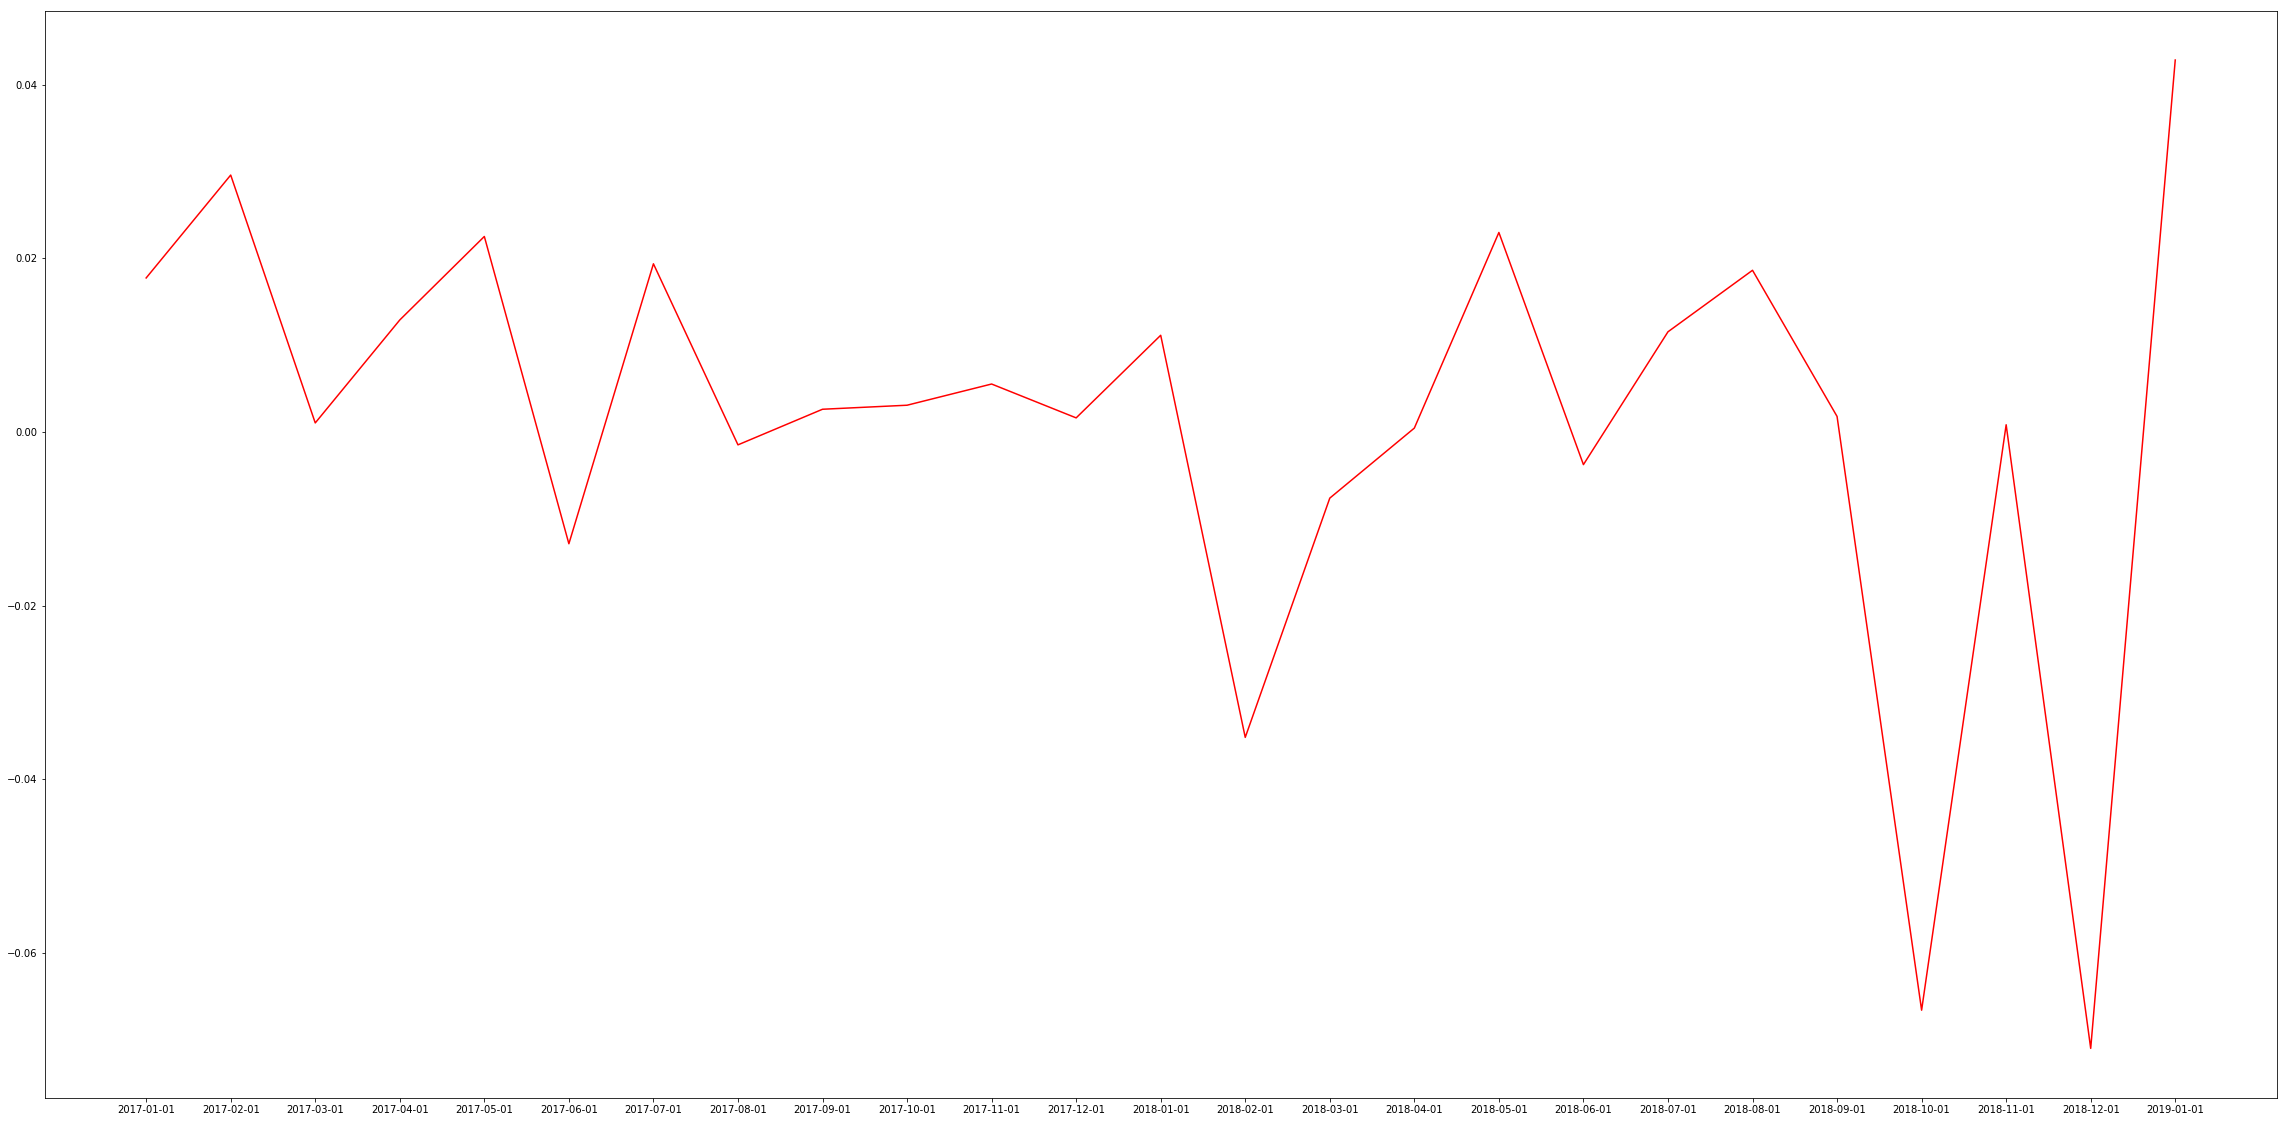

In [16]:
plt.figure(figsize=(40,20))
plt.plot(test,'r')

In [124]:
print(test.mean(),rfrate,sp500_re.mean())

0    0.001104
dtype: float64 0.0020482083333333333 0    0.008203
dtype: float64


In [21]:
store = 1
store_sp = 1
store_nor =1
agr_val = []
agr_val_sp = []
agr_norisk = []
for i in range(len(test)):
    value = store * (1+test.iloc[i])
    store = value
    agr_val.append(store)
    value_sp = store_sp * (1+sp500_re.iloc[i])
    store_sp = value_sp
    agr_val_sp.append(store_sp)
    value_no = store_nor * (1+rfrate/4)
    store_nor = value_no
    agr_norisk.append(value_no)

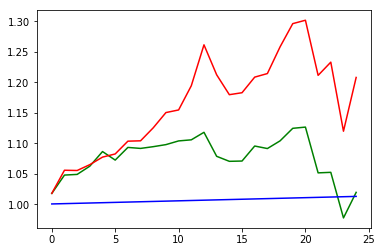

In [22]:
plt.plot(agr_val,'g')
plt.plot(agr_val_sp,'r')
plt.plot(agr_norisk,'b')

In [18]:
sp500 = pd.read_csv("C:\\Users\\USER\\Desktop\\^GSPC (2).csv")
sp500_1 = sp500[sp500['Date']>'2016-11-25']
sp500_2 = sp500_1[sp500_1['Date']<='2019-01-01']
return_sp500 = []
sp500_list = sp500_2['Adj Close'].tolist()
for i in range(len(sp500_2)-1) :
    return_sp500.append((sp500_list[i+1] - sp500_list[i]) / sp500_list[i])
sp500_re = pd.DataFrame(return_sp500)
sp500_re.iloc[0,:]

0    0.017884
Name: 0, dtype: float64

In [44]:
mixa = pd.concat([test.reset_index(),pd.DataFrame(agr_norisk),b],axis=1)
mixa.columns = ['Date','re','no_risk','ind','agr_r']

In [49]:
mixa = mixa.drop(['re','ind'],axis=1)

In [23]:
test.to_csv('month_return.csv')

In [27]:
pd.DataFrame(agr_norisk).to_csv('month_norisk.csv')

In [25]:
sp500_re.to_csv('sp500_month_return.csv')

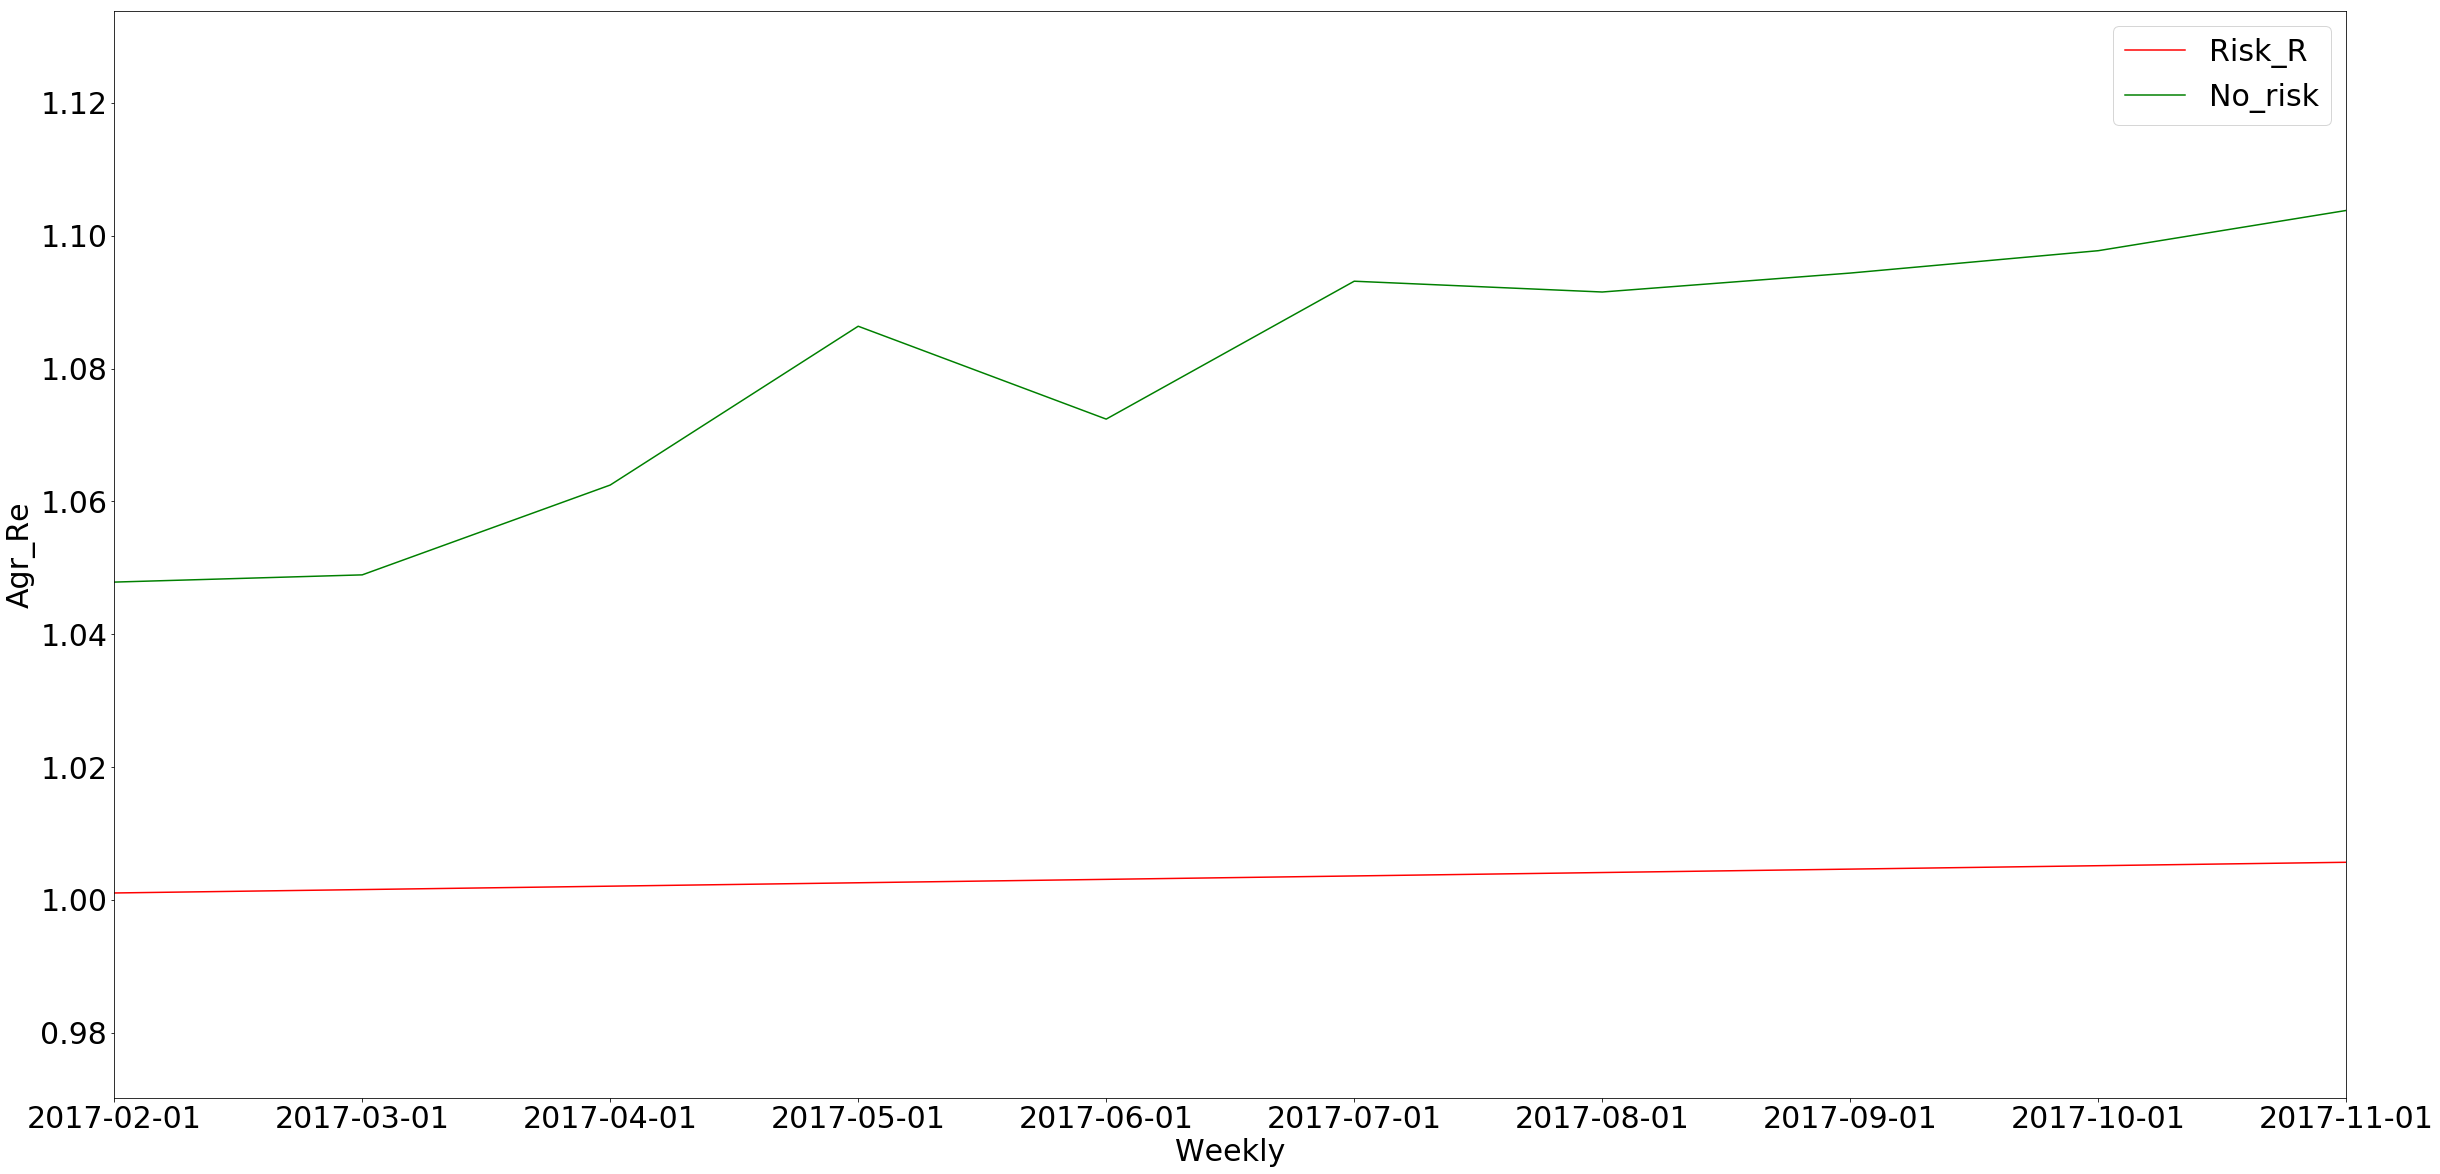

In [64]:
plt.figure(figsize=(40,20))
plt.plot(c,'r',label = 'Risk_R')
plt.plot(d,'g',label = 'No_risk')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Weekly',fontsize= 30)
plt.ylabel('Agr_Re',fontsize=30)
plt.legend(fontsize=30)

In [57]:
c = a.set_index('Date')
d = b.set_index('Date')

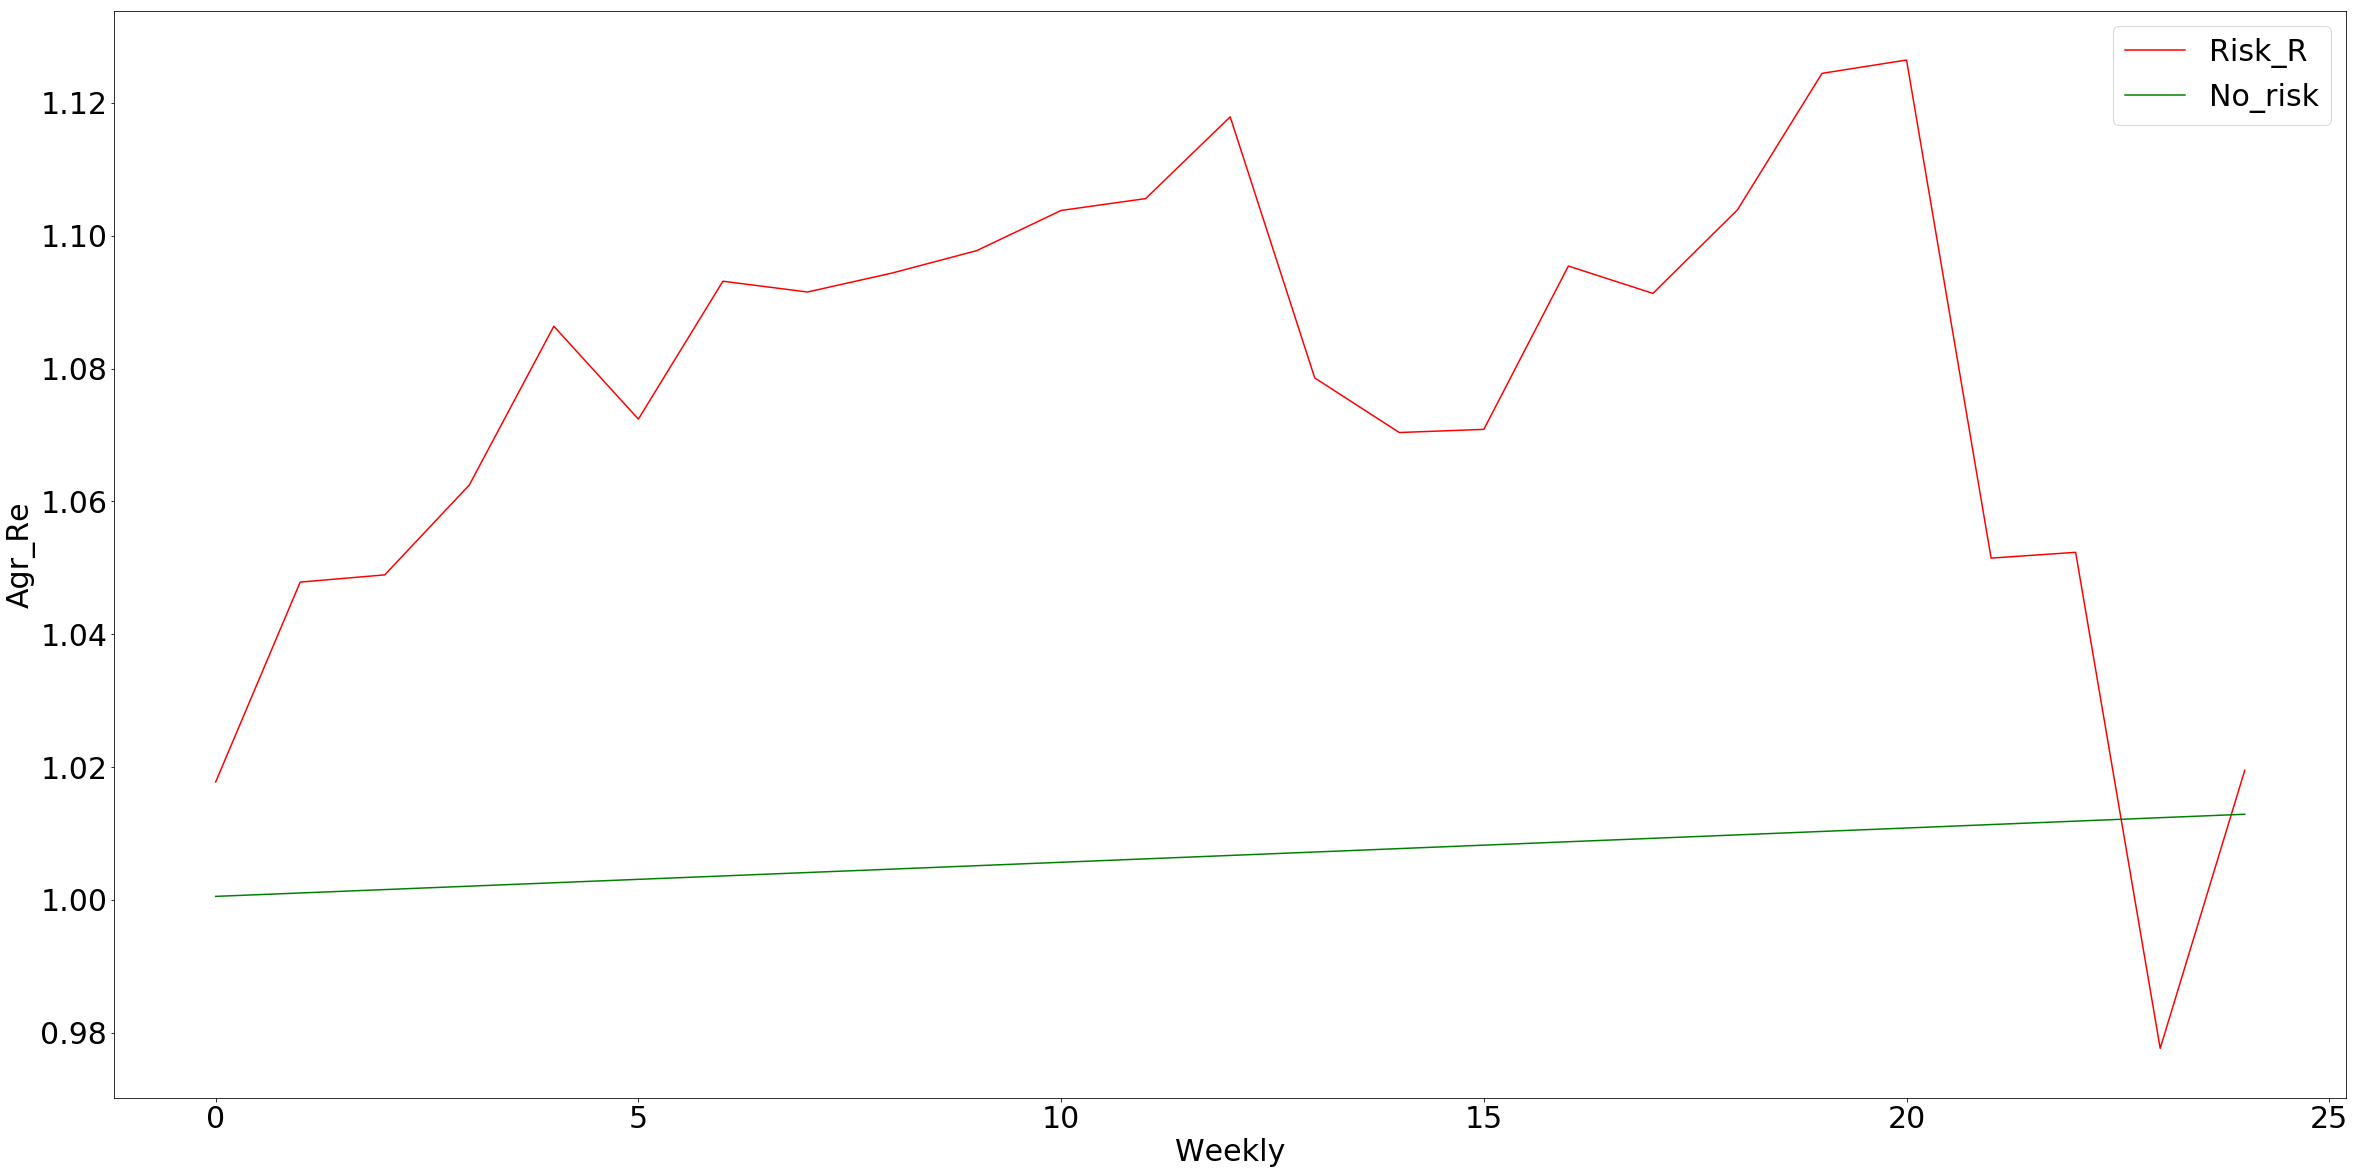

In [65]:
plt.figure(figsize=(40,20))
plt.plot(agr_val,'r',label = 'Risk_R')
plt.plot(agr_norisk,'g',label = 'No_risk')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Weekly',fontsize= 30)
plt.ylabel('Agr_Re',fontsize=30)
plt.legend(fontsize=30)